In [1]:
# Load libraries and functions
%load_ext autoreload
%autoreload 2
%matplotlib inline
RANDOM_STATE = 42  # Pseudo-random state

from utils import *
sns.set_palette("tab10") # Default seaborn theme

# Extra libraries for this notebook
from matplotlib.transforms import ScaledTranslation
import researchpy as rp

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Upload main dataset
fn_vae_data = glob.glob('./data/Updated*.pkl')
latest_fn_vae_data = max(fn_vae_data, key=os.path.getctime)

print("Loading... ",latest_fn_vae_data)
with open(latest_fn_vae_data, "rb") as f:
    vae_data_main = pickle.load(f)
    
fn_microbio = glob.glob('./data/Microbiology_full*.pkl') 
latest_fn_microbio = max(fn_microbio, key=os.path.getctime)
print("Loading... ",latest_fn_microbio)
with open(latest_fn_microbio, "rb") as f1:
    df = pickle.load(f1)
    
print("Done")


Loading...  ./data/Updated_VAE_Data_Main_0821_0932.pkl
Loading...  ./data/Microbiology_full_0821_1021.pkl
Done


In [3]:
# Match microbio dataset to ID_subid in main dataset by date (+3 days to account for testing delay)
vdm = vae_data_main.copy() # just in case
df_to_join = df[['date', 'ID']].reset_index()
list_to_join = [df_to_join]
for i in range(1, 4):  # adding three days to be sure about join
    tmp = df_to_join.copy()
    tmp.date = tmp.date.apply(lambda x: x + np.timedelta64(i, 'D'))
    list_to_join += [tmp]
    del tmp
df_to_join = pd.concat(list_to_join)

# Add ID_subid by new date to the microbiology dataframe
tests = df_to_join.merge(vdm, on=['date', 'ID']).groupby('index').ID_subid.min()
df_tests = pd.DataFrame(tests).join(df)

In [4]:
# Add groups annotation column
mask = {
    '0000': 'No HAI',
    '1011': 'NVA-HARTI',
    '1101': 'VA-HARTI',
    '0001': 'Other HAI',
    '1111': 'VA-HARTI'
}
def map_label(row):
    mask_ = f'{int(row[0])}{int(row[1])}{int(row[2])}{int(bool(row[3]))}'
    return mask[mask_]

groups = vae_data_main[['ID_subid', 'infection_respiratory', 'vap',
                        'non_vap_resp_hai', 'hai']].groupby('ID_subid').max().apply(map_label, axis=1)
groups_dict = groups.to_dict()

# Map groups by ID_subid
df_tests['group'] = df_tests.ID_subid.map(groups_dict)


In [5]:
# Combine rare bacteria into 'other' category
others = {'Corynebacterium sp' : 'Other bacteria',
          'Gram-negative bacteria' : 'Other bacteria',
          'Gram-positive cocci' : 'Other bacteria',
          'Pseudomonas other' : 'Other bacteria',
          'Streptococcus unidentified' : 'Other bacteria',
          'Haemophilus influenzae' : 'Other bacteria',
          'Acinetobacter other' : 'Other bacteria',
          'Citrobacter sp' : 'Other bacteria',
          'Morganella morganii' : 'Other bacteria',
          'Klebsiella other' : 'Other bacteria',
          'Burkholderia sp' : 'Other bacteria',
          'Streptococcus pneumoniae' : 'Other bacteria'
         }

df_tests.loc[:, ['bacteria_name']] = df_tests.loc[:, ['bacteria_name']].replace(others)

# The microbiological spectrum of pathogens causing VA and NVA-HARTI

## Overall spectrum

Select data by groups

In [6]:
# Select only HARTI patients
df_inf = pd.concat([df_tests[(df_tests.group == 'VA-HARTI')],
                    df_tests[(df_tests.group == 'NVA-HARTI')],
                    df_tests[(df_tests.group == 'VA+NVA HARTI')]], axis=0)

# Select only tests with HARTI-specific speciments
harti_speciments = ('bal', 'endotracheal_aspirate', 'discharge_maxillary_sinus',
                    'sputum', 'mucosa_tracheal', 'mucosa_pharyngeal', 'fluid_pleural',
                    'discharge_frontal_sinus', 'mucosa_nasal', 'mucosa_lingual')
df_inf = df_inf[df_inf.speciment.isin(harti_speciments)]

# Drop steril cultures and cultures without identified bacteria
df_inf = df_inf[df_inf.culture_steril == 0]
df_inf = df_inf[~df_inf.bacteria_name.isna()]

# Match ID_subid and ir_first_date from main dataset
df_inf = df_inf.merge(vae_data_main[['ID_subid', 'ir_first_date']].groupby(
    'ID_subid').max().reset_index(), on='ID_subid')

In [7]:
# Select only one test for one episode of HARTI
# closest to the first day of infection (3 days back / as needed forward)

def return_mask(x):
    val = x.rolling(2).agg(lambda x: x.iloc[1] - x.iloc[0] == 1).fillna(0)
    val = val[val == 1]
    return val.index

infections = vae_data_main[['ID_subid', 'infection_respiratory', 'date']].groupby('ID_subid').apply(
    lambda x: x.loc[return_mask(x['infection_respiratory'])])

infections = infections[['ID_subid', 'date']].reset_index(level=1)[['ID_subid', 'date']]
infections = infections.reset_index(drop=True)
    
values = []
for id_subid, date in infections.values:
    val = df_inf[(df_inf.ID_subid == id_subid) & (df_inf.date >= (date - np.timedelta64(3, 'D')))]
    for infection_date in sorted(val.date.unique()):
        if val[val.date == infection_date].antibiotic.isna().all():  # keep searching
            continue
        else:  # ok test was found
            val = val[val.date == val.date.min()]
            val['infection_date'] = date
            values += [val]
            break
    
df_inf = pd.concat(values)

In [8]:
# Remove non-pathogens
df_inf = df_inf.loc[~df_inf.bacteria_name.isin(['Staphylococcus CoN', 'Candida albicans', 'Candida other']), :]

In [9]:
# Select VA-HARTI patients from df_inf dataset
df_vap = df_inf[(df_inf.group == 'VA-HARTI')]
#Group by culture_id to select unique bacteria
df_vap = df_vap[['ID_subid', 'culture_id', 'year', 'bacteria_name', 'group']].groupby('culture_id').max()

# Select NVA-HARTI patients
df_nva = df_inf[(df_inf.group == 'NVA-HARTI')]
#Group by culture_id to select unique bacteria
df_nva = df_nva[['ID_subid', 'culture_id', 'year', 'bacteria_name', 'group']].groupby('culture_id').max()

In [10]:
# Calculate descriptive statistics for VA-HARTI
f = pd.DataFrame()
for i in df_vap.ID_subid.unique():
    aa = df_inf[(df_inf.ID_subid == i)]
    f1 = aa[['bacteria_name', 'infection_date']].groupby('infection_date')['bacteria_name'].nunique()
    f = pd.concat([f, f1], axis=0)
print("VA cases with identified pathogens: ", len(f), len(f) / 528)
print("Average number of causative pathogens per case: ", f.mean()[0], f.std()[0])
f[0].value_counts()

VA cases with identified pathogens:  436 0.8257575757575758
Average number of causative pathogens per case:  1.5137614678899083 0.6304850006741468


1.0    243
2.0    163
3.0     29
4.0      1
Name: 0, dtype: int64

In [11]:
# Calculate descriptive statistics for NVA-HARTI
f = pd.DataFrame()
for i in df_nva.ID_subid.unique():
    aa = df_inf[(df_inf.ID_subid == i)]
    f1 = aa[['bacteria_name', 'infection_date']].groupby('infection_date')['bacteria_name'].nunique()
    f = pd.concat([f, f1], axis=0)
print("NVA cases with identified pathogens: ", len(f), len(f) / 220)
print("Average number of causative pathogens per case: ", f.mean()[0])
f[0].value_counts()

NVA cases with identified pathogens:  134 0.6090909090909091
Average number of causative pathogens per case:  1.544776119402985


1.0    72
2.0    52
3.0     9
4.0     1
Name: 0, dtype: int64

In [12]:
# Show summary on number of isolates by groups and bacteria
df_inf_short = df_inf[['ID_subid', 'culture_id', 'year', 'bacteria_name', 'group']].groupby('culture_id').max()
crosstab = pd.crosstab(df_inf_short.bacteria_name, df_inf_short.group)
print('Total # isolates from HARTI patients: ', crosstab.sum().sum())
print(crosstab.sum())
print(crosstab.sum(axis=1))

Total # isolates from HARTI patients:  924
group
NVA-HARTI    222
VA-HARTI     702
dtype: int64
bacteria_name
Acinetobacter baumannii         174
Enterobacter sp                  42
Enterococcus sp                 110
Escherichia coli                 32
Klebsiella pneumoniae           201
Other bacteria                   41
Other fungi                       1
Proteus sp                       28
Pseudomonas aeruginosa          118
Serratia sp                      22
Staphylococcus aureus            90
Staphylococcus other             12
Stenotrophomonas maltophilia     12
Streptococcus viridans group     41
dtype: int64


________

## Spectrum by years
#### VA-HARTI group

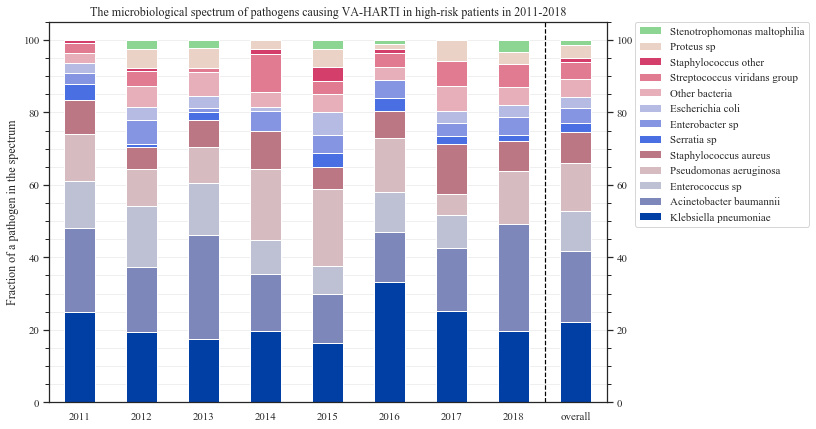

In [14]:
# calculate spectrum by years
vap_years = {}
for i in range(2011, 2019):
    vap_years[i] = df_vap[(df_vap.year ==i)].bacteria_name.value_counts() / df_vap[(df_vap.year ==i)].bacteria_name.value_counts().sum()
vap_years = pd.DataFrame.from_dict(vap_years)*100
vap_years['overall'] = df_vap.bacteria_name.value_counts() / df_vap.bacteria_name.value_counts().sum() *100
vap_years = vap_years.sort_values(by=[2011], ascending=False)

# Plot spectrum by years
colors = ["#023FA5","#7D87B9","#BEC1D4","#D6BCC0","#BB7784","#4A6FE3",
          "#8595E1","#B5BBE3","#E6AFB9","#E07B91","#D33F6A","#EAD3C6",
          "#8DD593","#C6DEC7","#0FCFC0", "#9CDED6"]

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
fig, ax = plt.subplots(1, figsize=(10,7))
values = vap_years.T
values.plot.bar(stacked=True, color=colors, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='',
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(b=True, which='major', axis='y',alpha=0.3)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.3)
plt.xticks(rotation='horizontal')
plt.axvline(7.5, color='black', linestyle='--', linewidth=1.2)

plt.title('The microbiological spectrum of pathogens causing VA-HARTI in high-risk patients in 2011-2018')
plt.ylabel('Fraction of a pathogen in the spectrum')
plt.savefig('pictures/spectrum_VA-HARTI.pdf', bbox_inches="tight", dpi=600)

# Reset ax properties
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False


In [15]:
# Test the dynamics over the years by linear regression
pvals = []
d = vap_years.T
d = d.loc[(d.index.isin(range(2011, 2019)))]
for col in vap_years.index:
    a = linregress(d[col], np.arange(len(d[col]))).pvalue
    pvals.append(a)
pd.DataFrame(pvals, index=vap_years.index)

,0
Klebsiella pneumoniae,0.660277
Acinetobacter baumannii,0.954807
Enterococcus sp,NaN
Pseudomonas aeruginosa,0.928967
Staphylococcus aureus,0.464728
Serratia sp,NaN
Enterobacter sp,0.707082
Escherichia coli,NaN
Other bacteria,0.558721
Streptococcus viridans group,0.320166


#### NVA-HARTI group

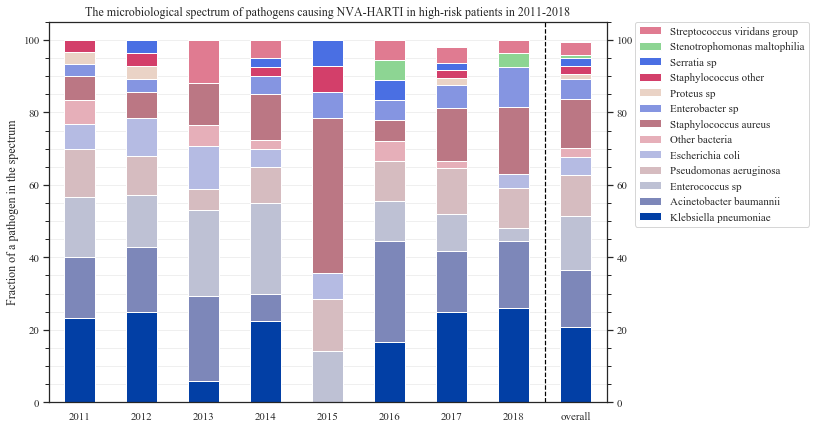

In [16]:
# calculate spectrum by years
nva_years = {}
for i in range(2011, 2019):
    nva_years[i] = df_nva[(df_nva.year ==i)].bacteria_name.value_counts() / df_nva[(df_nva.year ==i)].bacteria_name.value_counts().sum()
nva_years = pd.DataFrame.from_dict(nva_years)*100
nva_years['overall'] = df_nva.bacteria_name.value_counts() / df_nva.bacteria_name.value_counts().sum() *100
nva_years = nva_years.sort_values(by=[2011], ascending=False)
nva_years = nva_years[~(nva_years.index == 'Other fungi')]


# colors
colors = list(nva_years.index.map({k: v for k, v in zip(vap_years.index, colors)}))

# Plot spectrum by years
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
fig, ax = plt.subplots(1, figsize=(10,7))
values = nva_years.T
values.plot.bar(stacked=True, color=colors, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='',
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(b=True, which='major', axis='y',alpha=0.3)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.3)
plt.xticks(rotation='horizontal')
plt.axvline(7.5, color='black', linestyle='--', linewidth=1.2)

plt.title('The microbiological spectrum of pathogens causing NVA-HARTI in high-risk patients in 2011-2018')
plt.ylabel('Fraction of a pathogen in the spectrum')

plt.savefig('pictures/spectrum_NVA-HARTI.pdf', bbox_inches="tight", dpi=600)

# Reset ax properties
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False


In [17]:
# Test visible correlation between incidence of NVA-HARTI and % of Klebsiella 
nva_years = nva_years.fillna(0)
x = nva_years.drop(['overall'], axis=1)
x = x.T
x = x['Klebsiella pneumoniae']
y = [0.07540984, 0.08187135, 0.06486486, 0.09064327, 0.0480226 ,
        0.05205479, 0.08144796, 0.08695652]
r = np.corrcoef(x, y)
print("Pearson correlation coefficient: ", r[0, 1])
print("R2: ", r[0, 1]**2)
print(stats.spearmanr(x, y))


Pearson correlation coefficient:  0.8148195859068345
R2:  0.6639309575773852
SpearmanrResult(correlation=0.730552019767088, pvalue=0.039555627904297515)


In [18]:
# Test the dynamics over the years by linear regression
pvals = []
d = nva_years.T
d = d.loc[(d.index.isin(range(2011, 2019)))]
for col in nva_years.index:
    a = linregress(d[col], np.arange(len(d[col]))).pvalue
    pvals.append(a)
pd.DataFrame(pvals, index=nva_years.index)

,0
Klebsiella pneumoniae,0.845613
Acinetobacter baumannii,0.923387
Enterococcus sp,0.074212
Pseudomonas aeruginosa,0.718750
Escherichia coli,0.046073
Other bacteria,0.314309
Staphylococcus aureus,0.443118
Enterobacter sp,0.021953
Proteus sp,0.150693
Staphylococcus other,0.453755


### Compare overall spectrum in VA vs NVA-HARTI groups

In [20]:
# Compare 2 groups by chi-squared test 
table, results = rp.crosstab(df_inf_short.bacteria_name, df_inf_short.group, prop= 'col', test= 'chi-square')
print(results)

# Post-hoc analysis to compare spectrum by bacteria
dummies = pd.get_dummies(df_inf_short['bacteria_name'])
pvals = pd.Series()
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df_inf_short.group)
    chi2, p, dof, expected = chi(crosstab)
    pvals[series] = p

# Combine all data in one table
a = rp.summary_cat(df_vap[['bacteria_name']])[['Outcome', 'Count', 'Percent']]
a.index = a.Outcome
a = a.drop(['Outcome'], axis=1)

b = rp.summary_cat(df_nva[['bacteria_name']])[['Outcome', 'Count', 'Percent']]
b.index = b.Outcome
b = b.drop(['Outcome'], axis=1)
tab = pd.concat([table['group']['All'], a, b, pvals], axis=1, sort=True)
tab.columns = ['percent_all', 'count_vap', 'percent_vap', 'count_nva', 'percent_nva', 'pvalue']
tab.to_csv('./table_4.csv', sep='\t', encoding='utf-8')
tab

                 Chi-square test  results
0  Pearson Chi-square ( 13.0) =   21.6388
1                     p-value =    0.0612
2                  Cramer's V =    0.1530


,percent_all,count_vap,percent_vap,count_nva,percent_nva,pvalue
Acinetobacter baumannii,18.83,139.0,19.80,35.0,15.77,0.214306
All,100.00,NaN,NaN,NaN,NaN,NaN
Enterobacter sp,4.55,30.0,4.27,12.0,5.41,0.602446
Enterococcus sp,11.90,77.0,10.97,33.0,14.86,0.148853
Escherichia coli,3.46,21.0,2.99,11.0,4.95,0.236390
Klebsiella pneumoniae,21.75,155.0,22.08,46.0,20.72,0.738009
Other bacteria,4.44,35.0,4.99,6.0,2.70,0.210239
Other fungi,0.11,NaN,NaN,1.0,0.45,0.543004
Proteus sp,3.03,25.0,3.56,3.0,1.35,0.147154
Pseudomonas aeruginosa,12.77,93.0,13.25,25.0,11.26,0.510760


In [21]:
print('N of isolates VAP: ', tab.count_vap.sum())
print('N of isolates NVA: ', tab.count_nva.sum())
print('N of isolates all: ', tab.count_vap.sum() + tab.count_nva.sum())

N of isolates VAP:  702.0
N of isolates NVA:  222.0
N of isolates all:  924.0


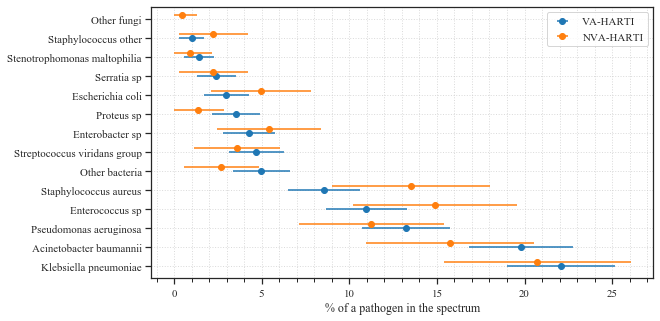

In [22]:
###### Show results on the plot
# Calculate % and 95% CI
dfs = [df_vap, df_nva]
spectrum = {}
for df in dfs:
    counts = df.bacteria_name.value_counts()
    s = pd.Series(counts / counts.sum())*100
    cil, cir = ci(counts, counts.sum())
    spectrum[df.shape[0]] = pd.DataFrame()
    spectrum[df.shape[0]] = pd.concat([s, cil*100, cir*100], axis=1)
    spectrum[df.shape[0]].columns=(['percentage', 'lower', 'upper'])
    
#Plot spectrum for HARTI patients by groups
fig, ax = plt.subplots(1, figsize=(9,5))
trans1 = ax.transData + ScaledTranslation(0, 0, fig.dpi_scale_trans)
for i in spectrum.keys():
    lower_error = spectrum[i].lower
    upper_error = spectrum[i].upper
    xerr=[spectrum[i].percentage-lower_error, upper_error-spectrum[i].percentage]
    ax.errorbar(spectrum[i].percentage, spectrum[i].index, xerr=xerr, fmt='o', transform=trans1)
    trans1 = ax.transData + ScaledTranslation(0, 0.05, fig.dpi_scale_trans)
ax.legend(['VA-HARTI', 'NVA-HARTI'])
ax.minorticks_on()
ax.grid(which='major', linestyle='dotted', alpha=0.7)
ax.grid(which='minor', axis='x', linestyle='dotted', alpha=0.7)
ax.tick_params(axis='y', which='minor', left=False)
ax.tick_params(axis='x', which='both', bottom=True)
ax.set_xlabel('% of a pathogen in the spectrum')

plt.savefig('pictures/spectrum_compare.pdf', bbox_inches="tight", dpi=600)

__________

# Antibiotic resistance

In [23]:
# Aggregate data by culture_id
resistance_df = df_inf[['culture_id', 'antibiotic_class', 'resistance', 'year', 'group',
          'ID_subid','bacteria_name']].groupby(['culture_id','bacteria_name','antibiotic_class']).max()

def agg_func(x):
    if x.name == 'antibiotic_class': #how many different classes were tested
        return x.count()
    elif x.name == 'resistance': # how many classes with resistance
        return x.sum()
    elif x.name == 'year':
        return x.max()
    elif x.name == 'group':
        return x.max()

resistance_df = resistance_df.reset_index().groupby(['culture_id', 'bacteria_name', 'ID_subid']).agg(agg_func)

# Add columns PDR, XDR, MDR or resistant according to the CDC definition
resistance_df['pdr'] = (resistance_df.resistance == resistance_df.antibiotic_class)
resistance_df['xdr'] = (~resistance_df.pdr & ((resistance_df.antibiotic_class - resistance_df.resistance ) <= 2))
resistance_df['mdr'] = (~resistance_df.xdr) & (~resistance_df.pdr) & (resistance_df.resistance >= 3)
resistance_df['resistant'] = (~resistance_df.xdr) & (~resistance_df.pdr) & (resistance_df.resistance < 3) & (resistance_df.resistance >=1)
resistance_df = resistance_df.reset_index()

# Add ID column
resistance_df['ID'] = resistance_df.ID_subid.apply(lambda x: x[:-1])

# Add mortality column by ID
resistance_df = resistance_df.merge(vae_data_main[['ID', 'outcome_death']].groupby('ID').max().reset_index(), on='ID')
resistance_df.head()

,culture_id,bacteria_name,ID_subid,antibiotic_class,resistance,year,group,pdr,xdr,mdr,resistant,ID,outcome_death
0,802,Klebsiella pneumoniae,70/110,12,10,2011,NVA-HARTI,False,True,False,False,70/11,0
1,3535,Staphylococcus aureus,3111/110,13,2,2011,VA-HARTI,False,False,False,True,3111/11,0
2,11775,Klebsiella pneumoniae,2773/110,12,5,2011,VA-HARTI,False,False,True,False,2773/11,0
3,11776,Staphylococcus aureus,2773/110,13,2,2011,VA-HARTI,False,False,False,True,2773/11,0
4,13589,Escherichia coli,2667/110,12,5,2011,VA-HARTI,False,False,True,False,2667/11,0


In [24]:
# calculate % of pdr by year
test = resistance_df[['year', 'pdr']]
table, results = rp.crosstab(test.pdr, test.year, prop= 'col', test= 'chi-square')
table

year                                                              
        2011    2012    2013   2014    2015   2016    2017    2018     All
pdr                                                                       
False  100.0   96.69   92.47   97.8   98.73   93.1   85.71   97.47   95.13
True     0.0    3.31    7.53    2.2    1.27    6.9   14.29    2.53    4.87
All    100.0  100.00  100.00  100.0  100.00  100.0  100.00  100.00  100.00

### Compare overall resistance by groups

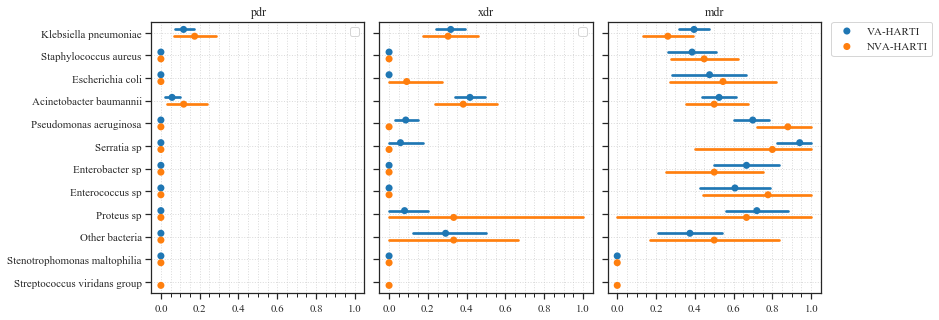

In [25]:
# Plot proroption with 95% CI
fig, ax = plt.subplots(1,3, figsize=(12,5), sharey = True)
ax = ax.ravel()
for i, col in enumerate(['pdr', 'xdr', 'mdr']):
    sns.pointplot(x=col, y="bacteria_name", hue='group', data=resistance_df, scale=0.8,
                  hue_order=['VA-HARTI', 'NVA-HARTI'], dodge=0.3, join=False, ax=ax[i])
    ax[i].legend('')
    ax[i].set_xlim(-0.05,1.05)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(col)
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dotted', alpha=0.7)
    ax[i].grid(which='minor', axis='x', linestyle='dotted', alpha=0.7)
    ax[i].tick_params(axis='y', which='minor', left=False)
    ax[i].tick_params(axis='x', which='both', bottom=True)
    ax[i].label_outer()
    handles, labels = ax[i].get_legend_handles_labels()
plt.subplots_adjust(wspace=0.07, hspace=0.07)
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('pictures/resistance_va-nva.pdf', bbox_inches="tight", dpi=600)

### Compare resistance by years and groups

In [26]:
# Test difference in resistance between groups
test = resistance_df[['mdr', 'xdr', 'pdr']]
ts = pd.concat([resistance_df[['ID_subid', 'group']], test.idxmax(axis=1)], axis=1)

# Compare 2 groups by chi-squared test 
table, results = rp.crosstab(ts[0], ts.group, prop= 'col', test= 'chi-square')
print(results)

# Post-hoc analysis to compare spectrum by bacteria
dummies = pd.get_dummies(ts[0])
pvals = pd.Series()
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], ts.group)
    chi2, p, dof, expected = chi(crosstab)
    pvals[series] = p
    nl = "\n"
    print(crosstab, nl)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

######## Because there is no difference, we plot both groups together below

                Chi-square test  results
0  Pearson Chi-square ( 2.0) =    2.5651
1                    p-value =    0.2773
2                 Cramer's V =    0.0573
group  NVA-HARTI  VA-HARTI
mdr                       
0             43       151
1            140       447 

Chi2 value= 0.14641643055549122
p-value= 0.7019837415301664
Degrees of freedom= 1

group  NVA-HARTI  VA-HARTI
pdr                       
0            171       572
1             12        26 

Chi2 value= 1.0390778224200437
p-value= 0.308036043027634
Degrees of freedom= 1

group  NVA-HARTI  VA-HARTI
xdr                       
0            152       473
1             31       125 

Chi2 value= 1.1400354567768995
p-value= 0.28564483544804176
Degrees of freedom= 1



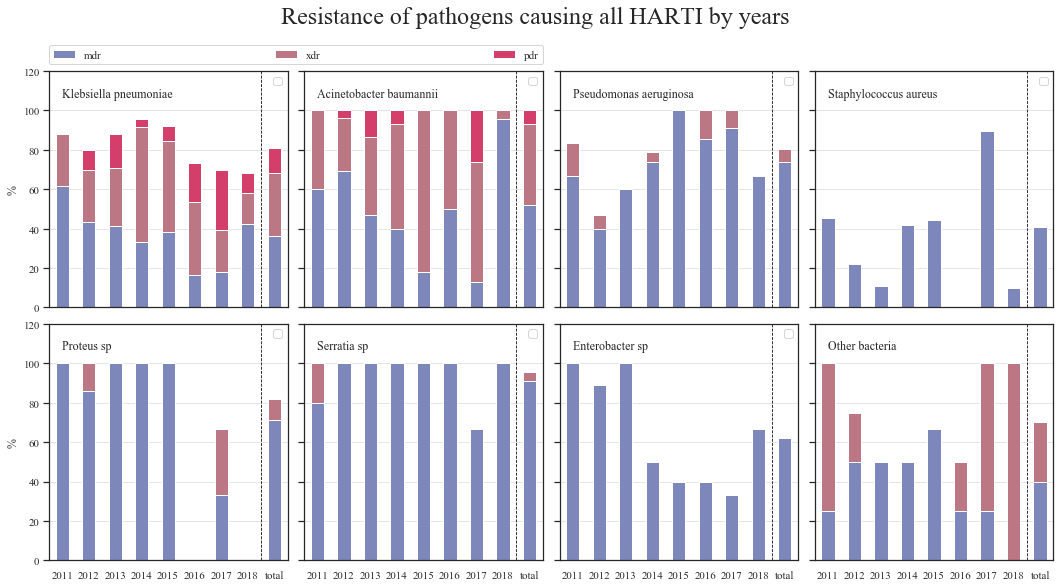

In [27]:
# VA-HARTI
resistance_count = {}
resistance_count_all = {}
for i in range(2011, 2019):
    un = pd.Series(resistance_df[(resistance_df.year ==i)].bacteria_name.value_counts())
    g = resistance_df[(resistance_df.year ==i)].groupby('bacteria_name').sum()
    g = g.loc[:, ['mdr', 'xdr', 'pdr']]
    resistance_count[i] = (g.divide(un, axis=0)*100).T
    resistance_count_all[i] = g.sum() / len(resistance_df[(resistance_df.year ==i)]) *100
overall = resistance_df.groupby('bacteria_name').sum().loc[:, ['mdr', 'xdr', 'pdr']]
un_all = pd.Series(resistance_df.bacteria_name.value_counts())
resistance_count['total'] = (overall.divide(un_all, axis=0)*100).T


# Select important pathogens to plot
pathogens = ('Klebsiella pneumoniae', 'Acinetobacter baumannii','Pseudomonas aeruginosa',
             'Staphylococcus aureus', 'Proteus sp', 'Serratia sp',
             'Enterobacter sp', 'Other bacteria')


dummy_series = pd.Series([np.NaN for _ in range(3)], index=['mdr', 'xdr', 'pdr'])
for k in ['Enterococcus sp', 'Escherichia coli']:
    for year in range(2011, 2019):
        if k not in resistance_count[year]:
            resistance_count[year][k] = dummy_series
            
colors = ["#7D87B9","#BB7784","#D33F6A",]

fig, ax = plt.subplots(2, 4, figsize=(18,9), sharey=True, sharex = True)
ax = ax.ravel()
for i, col in enumerate(pathogens):
    df = pd.DataFrame()
    for j in resistance_count.keys():
        a = resistance_count[j][col]
        df[j] = a
    df['total'] = resistance_count['total'][col]
    df.T.plot.bar(stacked=True, color=colors, ax=ax[i])
    ax[i].legend('')
    ax[i].axvline(7.5, color='black', linestyle='--', linewidth=0.8)
    ax[i].set_ylim(0,120)
    ax[i].text(0,107, col, fontsize=12)
    ax[i].grid(b=True, which='major', axis='y',alpha=0.5)
    ax[i].set_xticklabels(resistance_count.keys(), rotation=0)
    ax[i].set_ylabel('%')
    ax[i].label_outer()
    handles, labels = ax[i].get_legend_handles_labels()
plt.subplots_adjust(wspace=0.07, hspace=0.07)
plt.legend(handles, labels,
           bbox_to_anchor=(-3.21, 2.1, 2.07, 0.5),
           loc=8, ncol=3,
           mode="expand",
           borderaxespad=0.)
plt.suptitle('Resistance of pathogens causing all HARTI by years')
plt.savefig('pictures/spectrum_allHARTI_pathogens.pdf', bbox_inches="tight", dpi=600)

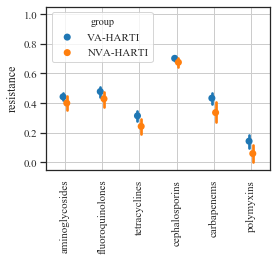

In [28]:
# Plot resistance to aminoglycosides in VA- and NVA-HARTI
important_abx = ['aminoglycosides', 'fluoroquinolones', 'tetracyclines', 'cephalosporins',
                 'carbapenems', 'polymyxins']
df_abx = df_inf[(df_inf.antibiotic_class.isin(important_abx))]
fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.pointplot(x="antibiotic_class", y = 'resistance', hue='group', data=df_abx, scale=0.8,
                  hue_order=['VA-HARTI', 'NVA-HARTI'], dodge=0.1, join=False, ax=ax)
ax.set_xticklabels(labels = important_abx, rotation=90)
ax.grid('dotted')
ax.set_ylim(-0.05,1.05)
ax.set_xlabel('')
plt.savefig('pictures/resistance_va_nva_all.pdf', bbox_inches="tight", dpi=600)

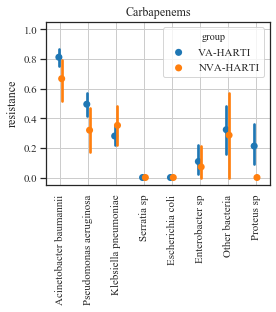

In [29]:
# Plot resistance to carbamenems in VA- and NVA-HARTI
carbapenems = df_inf[(df_inf.antibiotic_class == 'carbapenems') & (df_inf.bacteria_name != 'Stenotrophomonas maltophilia')]
fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.pointplot(x="bacteria_name", y = 'resistance', hue='group', data=carbapenems, scale=0.8,
                  hue_order=['VA-HARTI', 'NVA-HARTI'], dodge=0.1, join=False, ax=ax)
ax.set_xticklabels(labels=carbapenems.bacteria_name.unique(), rotation=90)
ax.set_ylim(-0.05,1.05)
ax.grid('dotted')
ax.set_xlabel('')
ax.set_title('Carbapenems')
plt.savefig('pictures/resistance_carbapenems.pdf', bbox_inches="tight", dpi=600)

## Resistance to all antibiotics

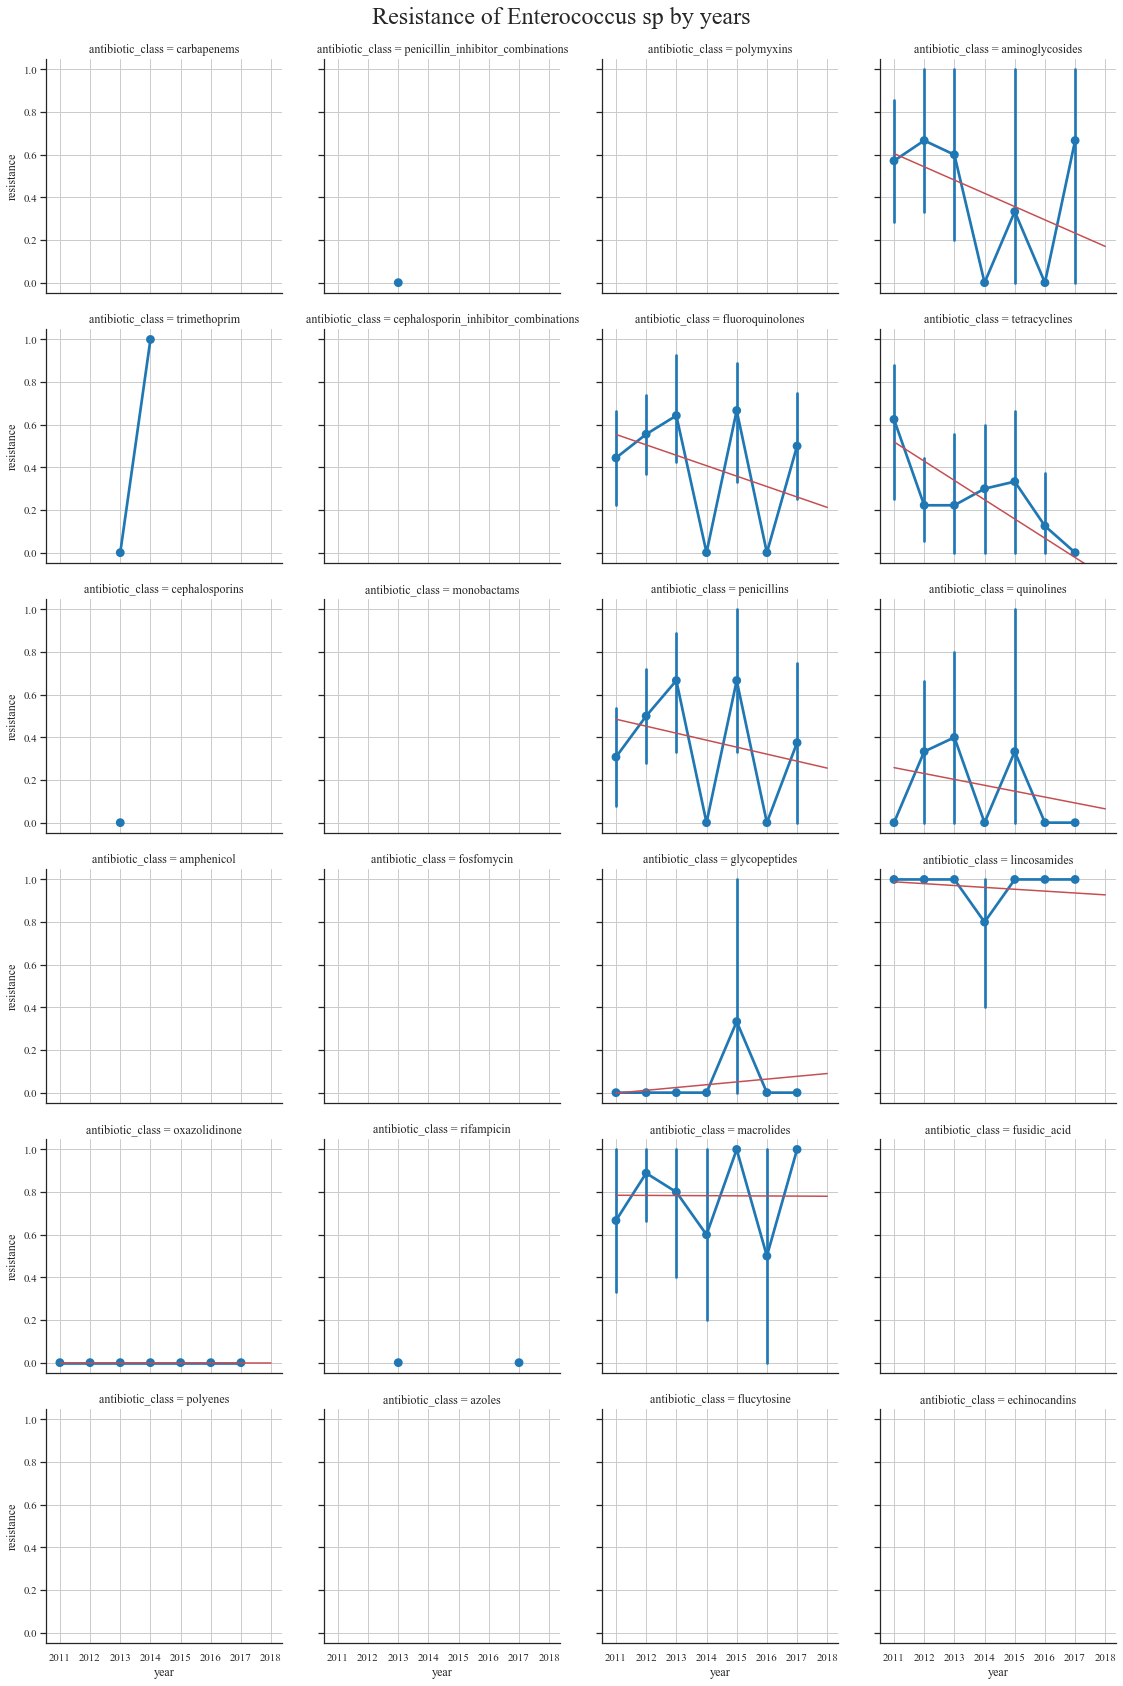

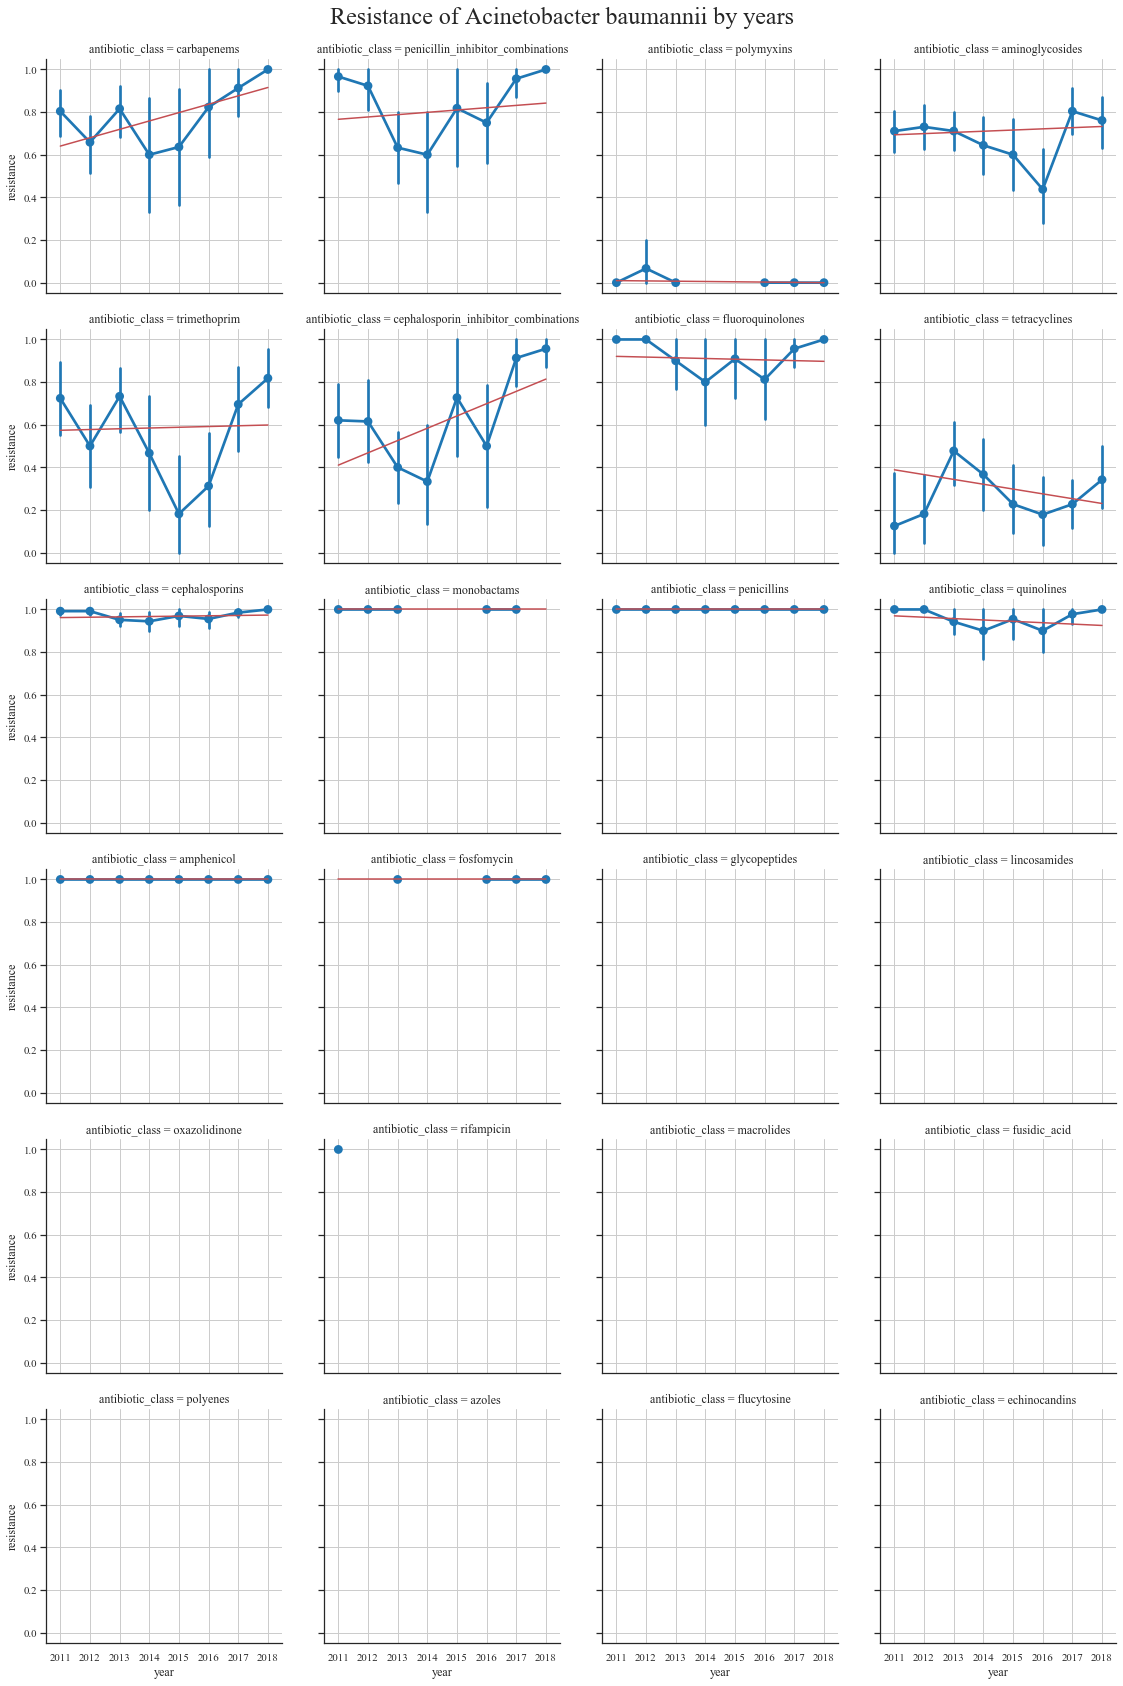

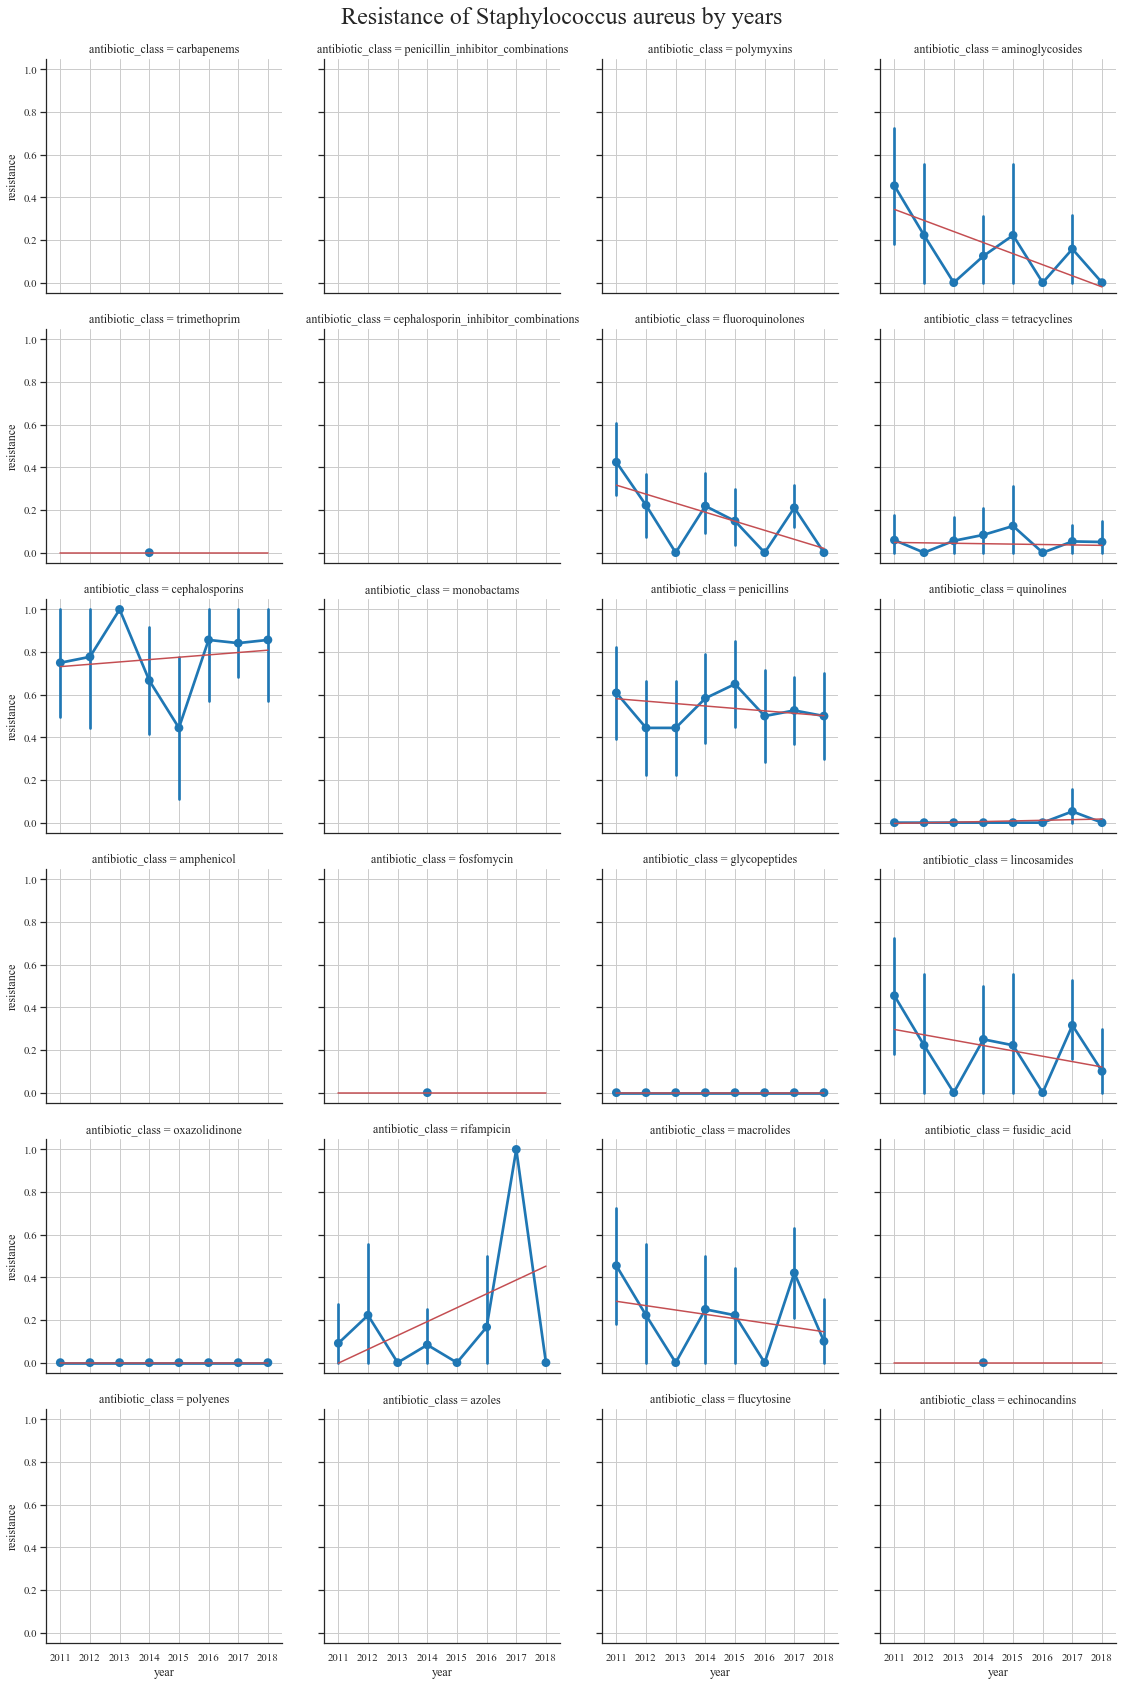

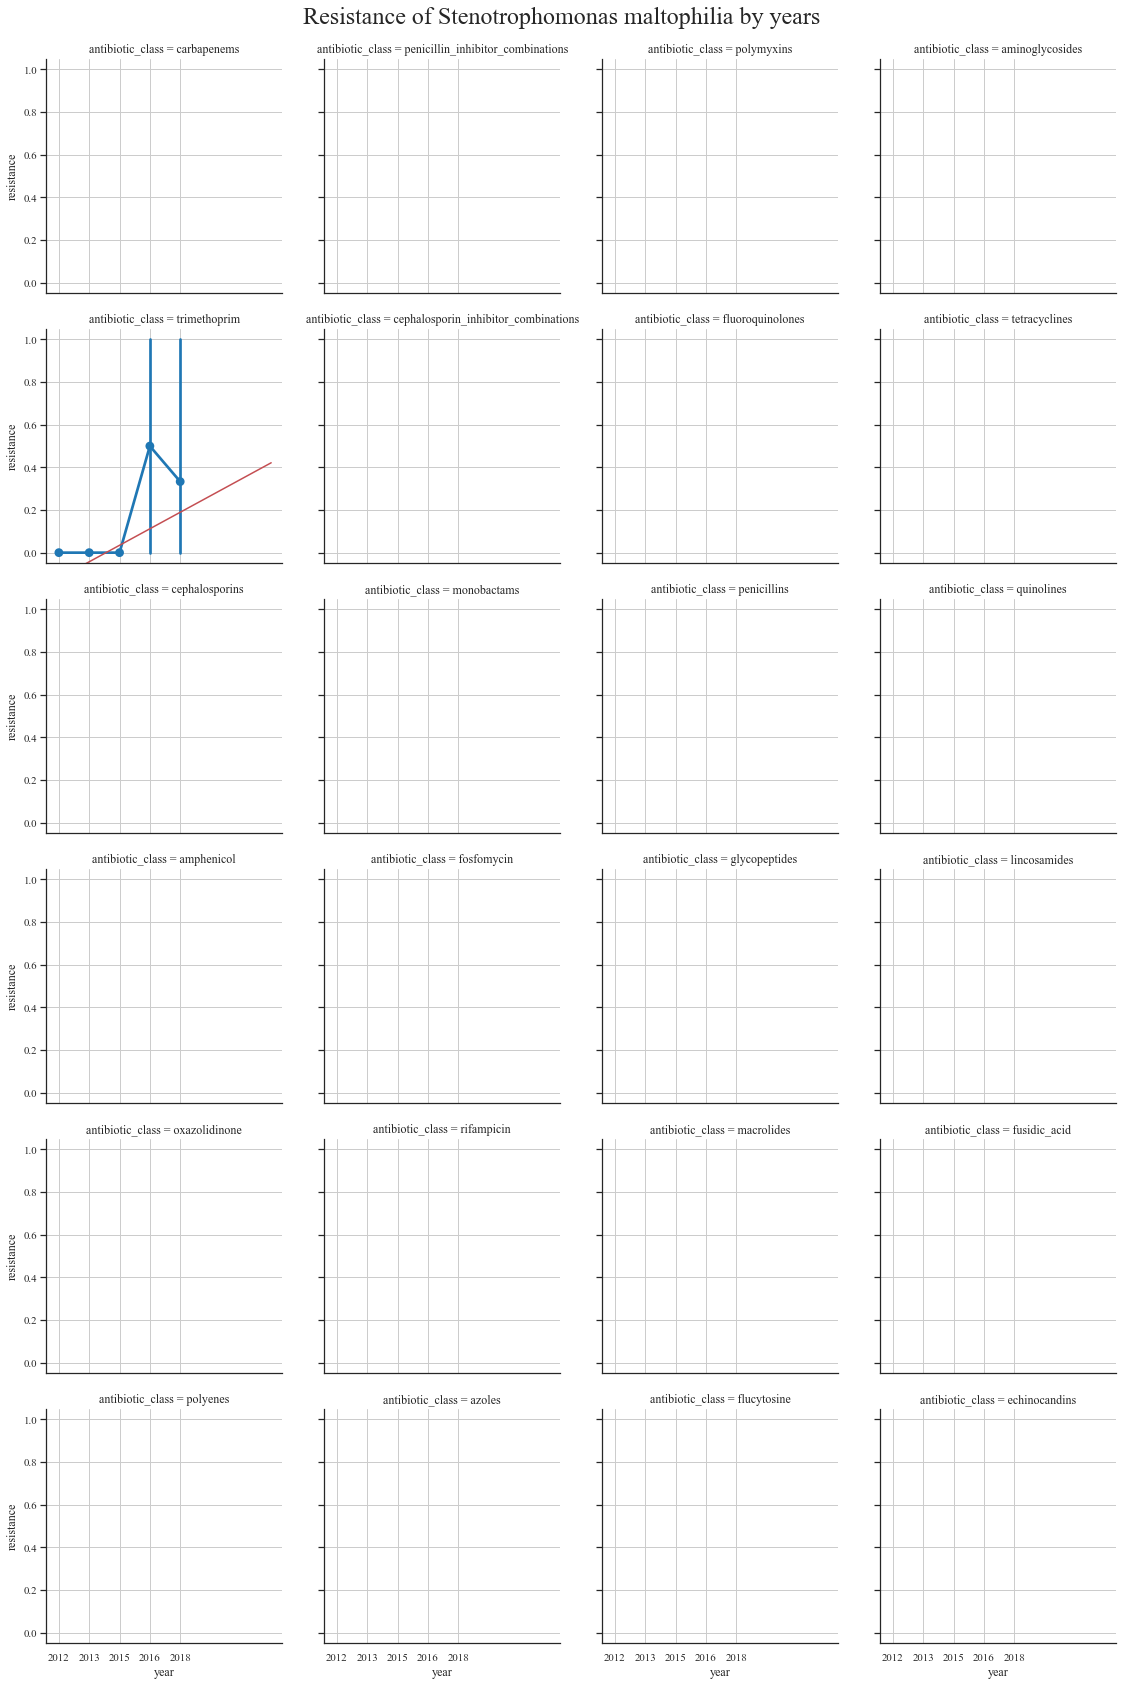

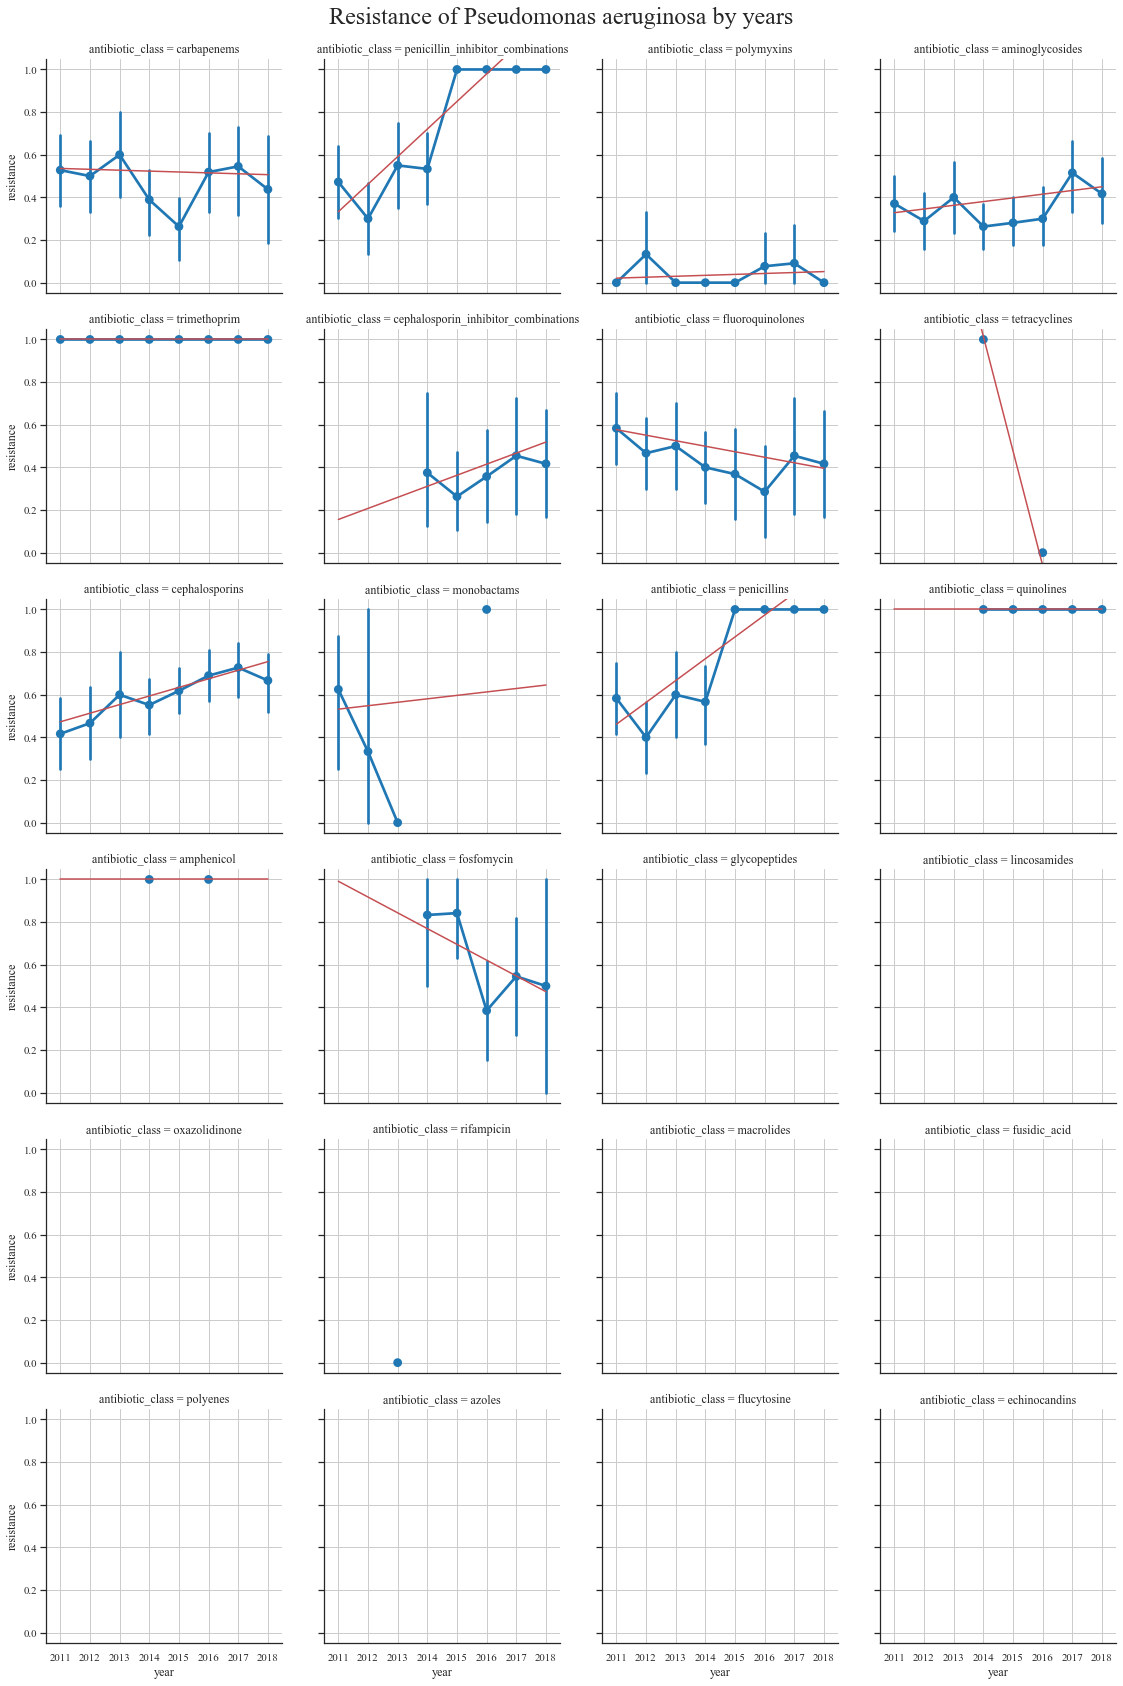

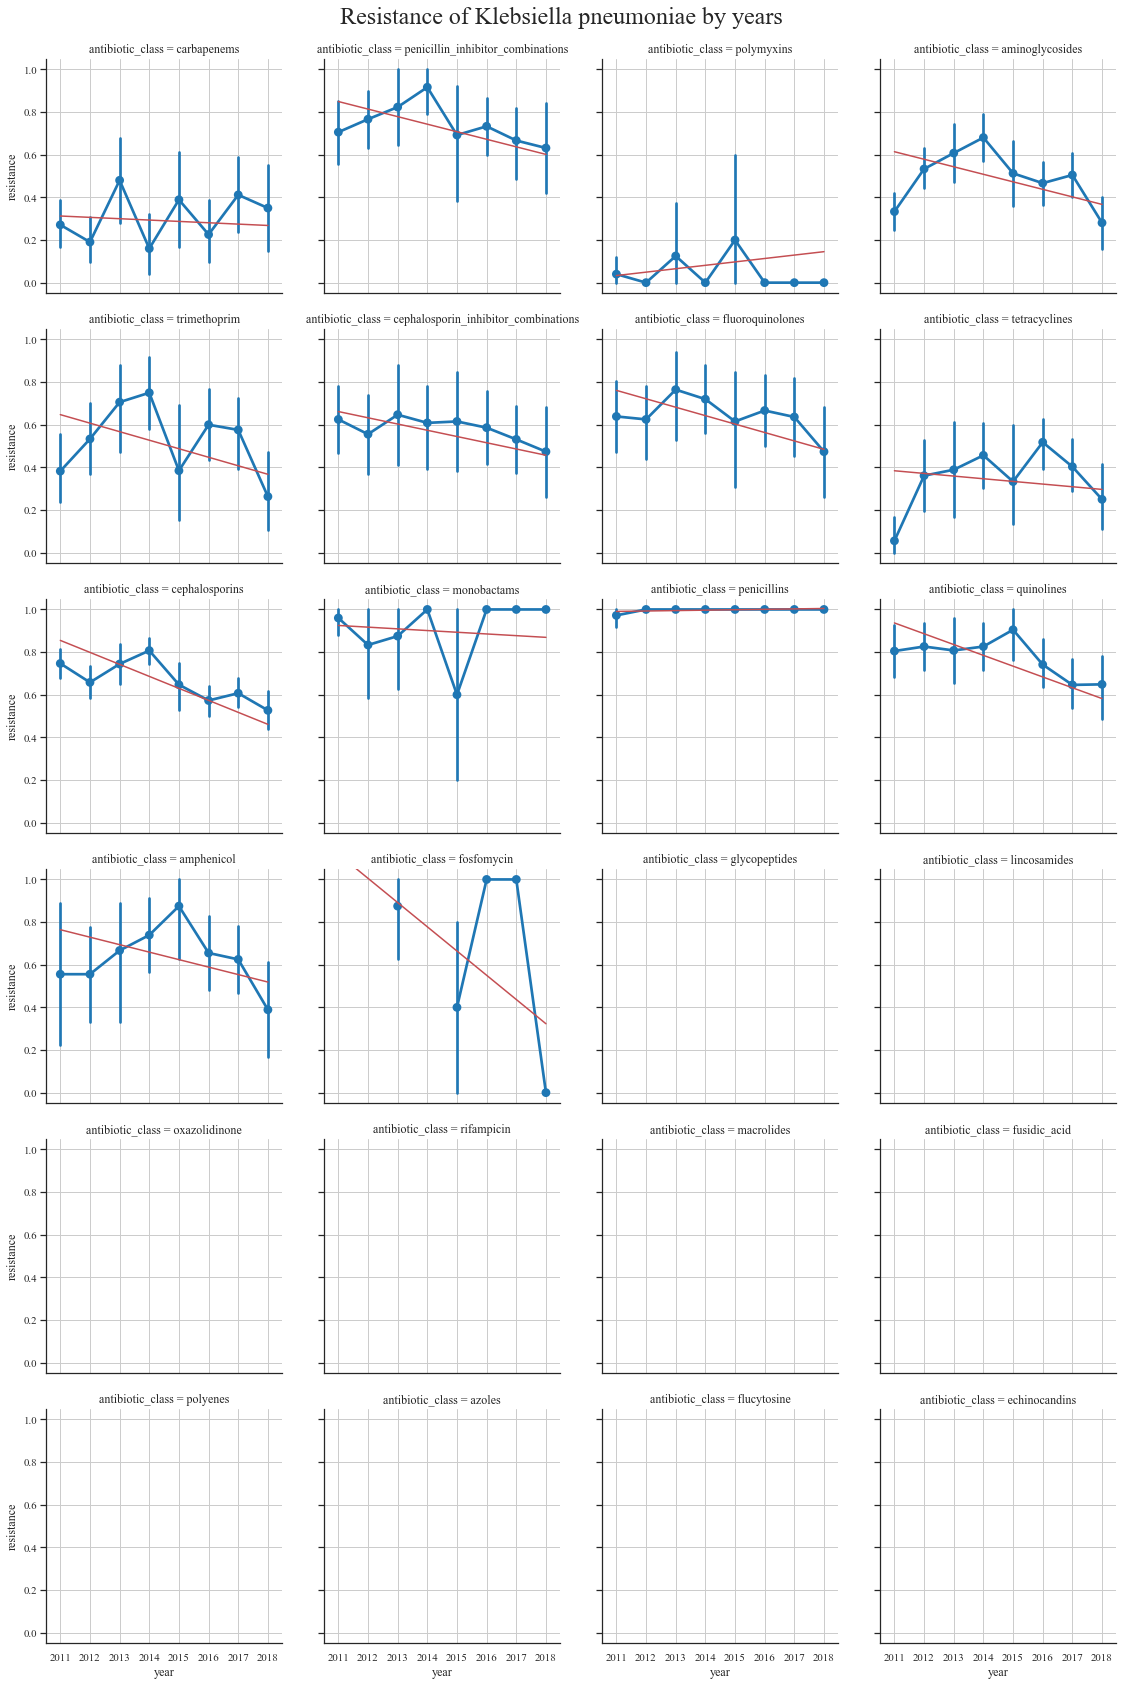

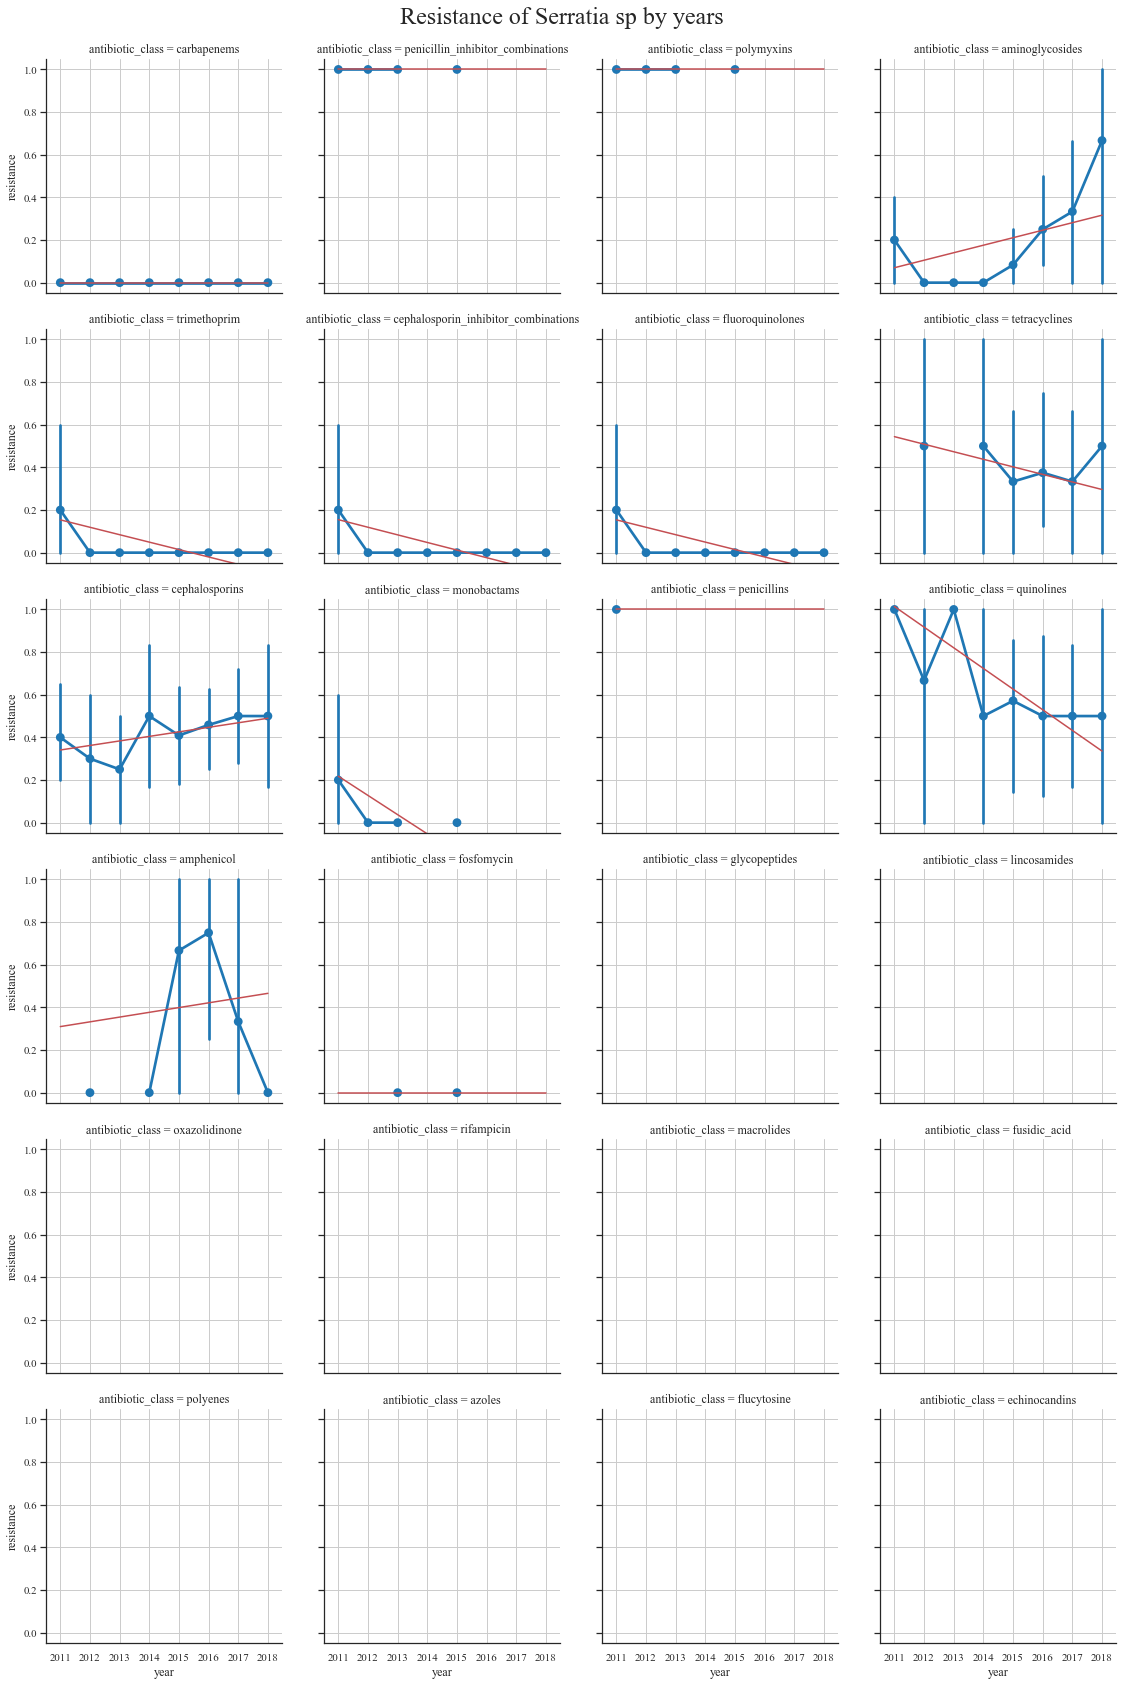

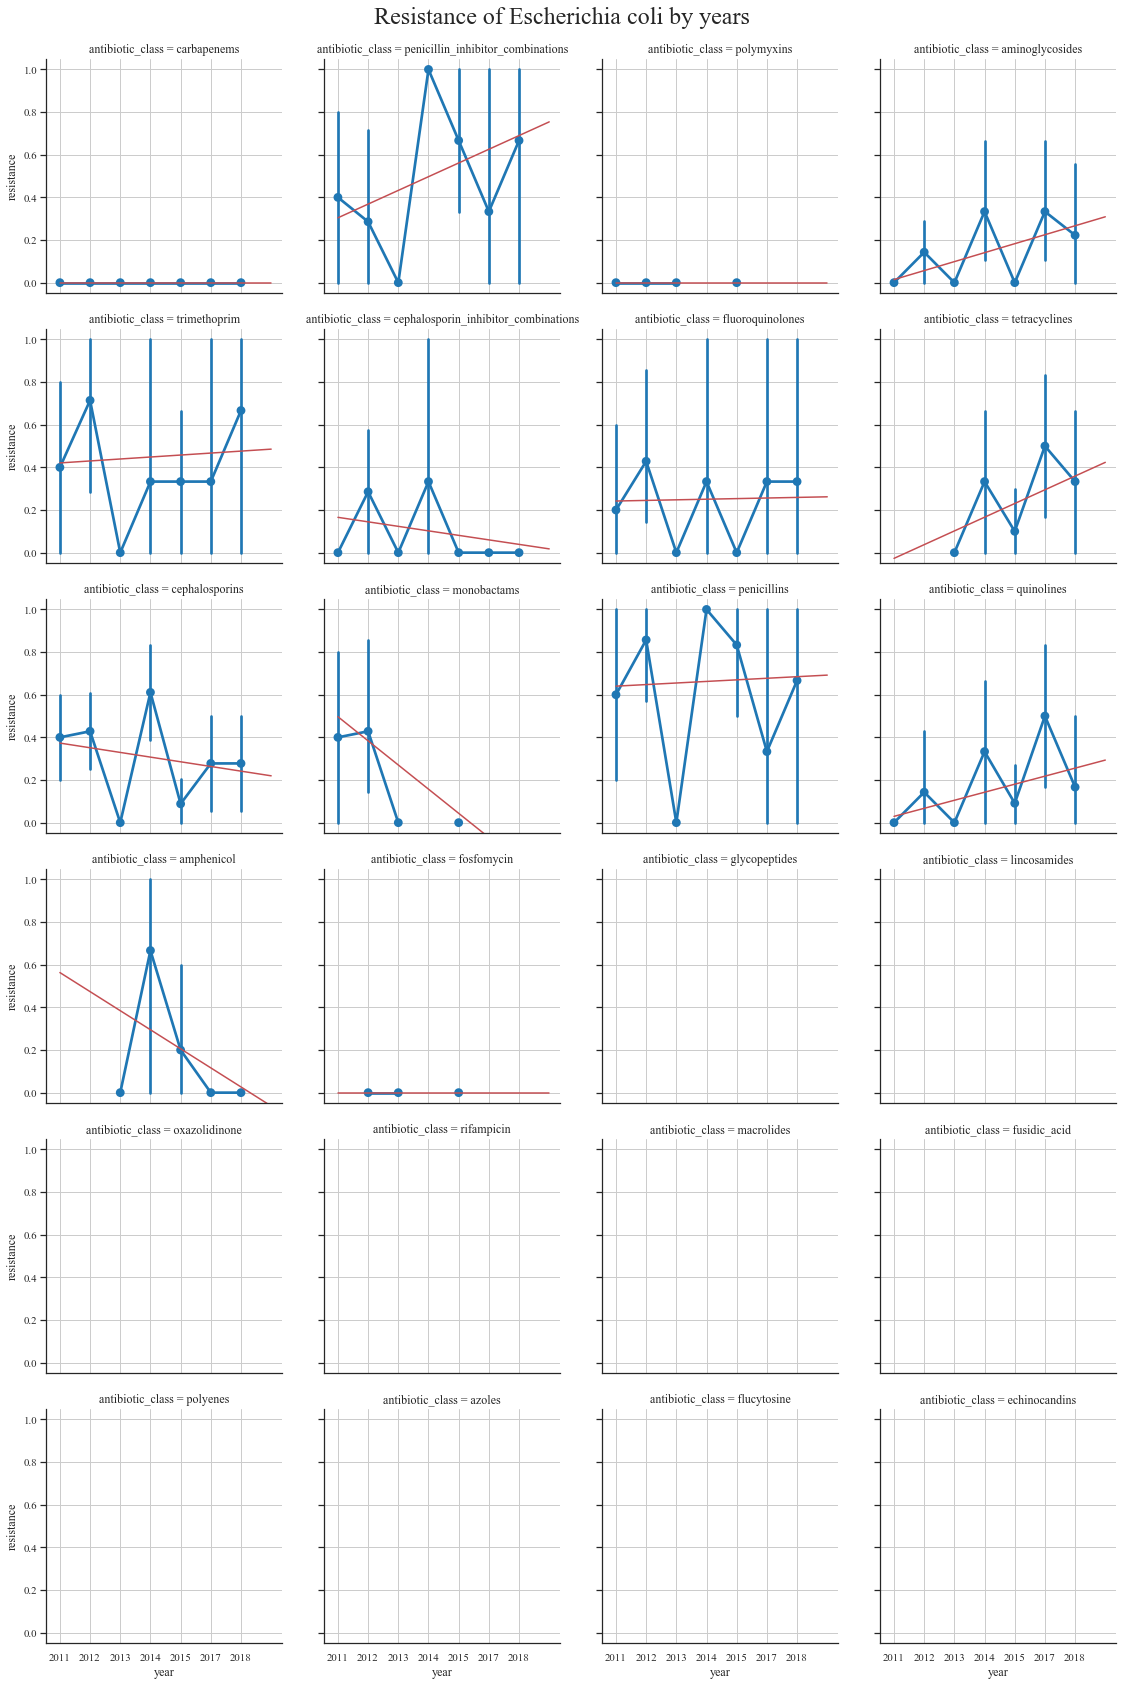

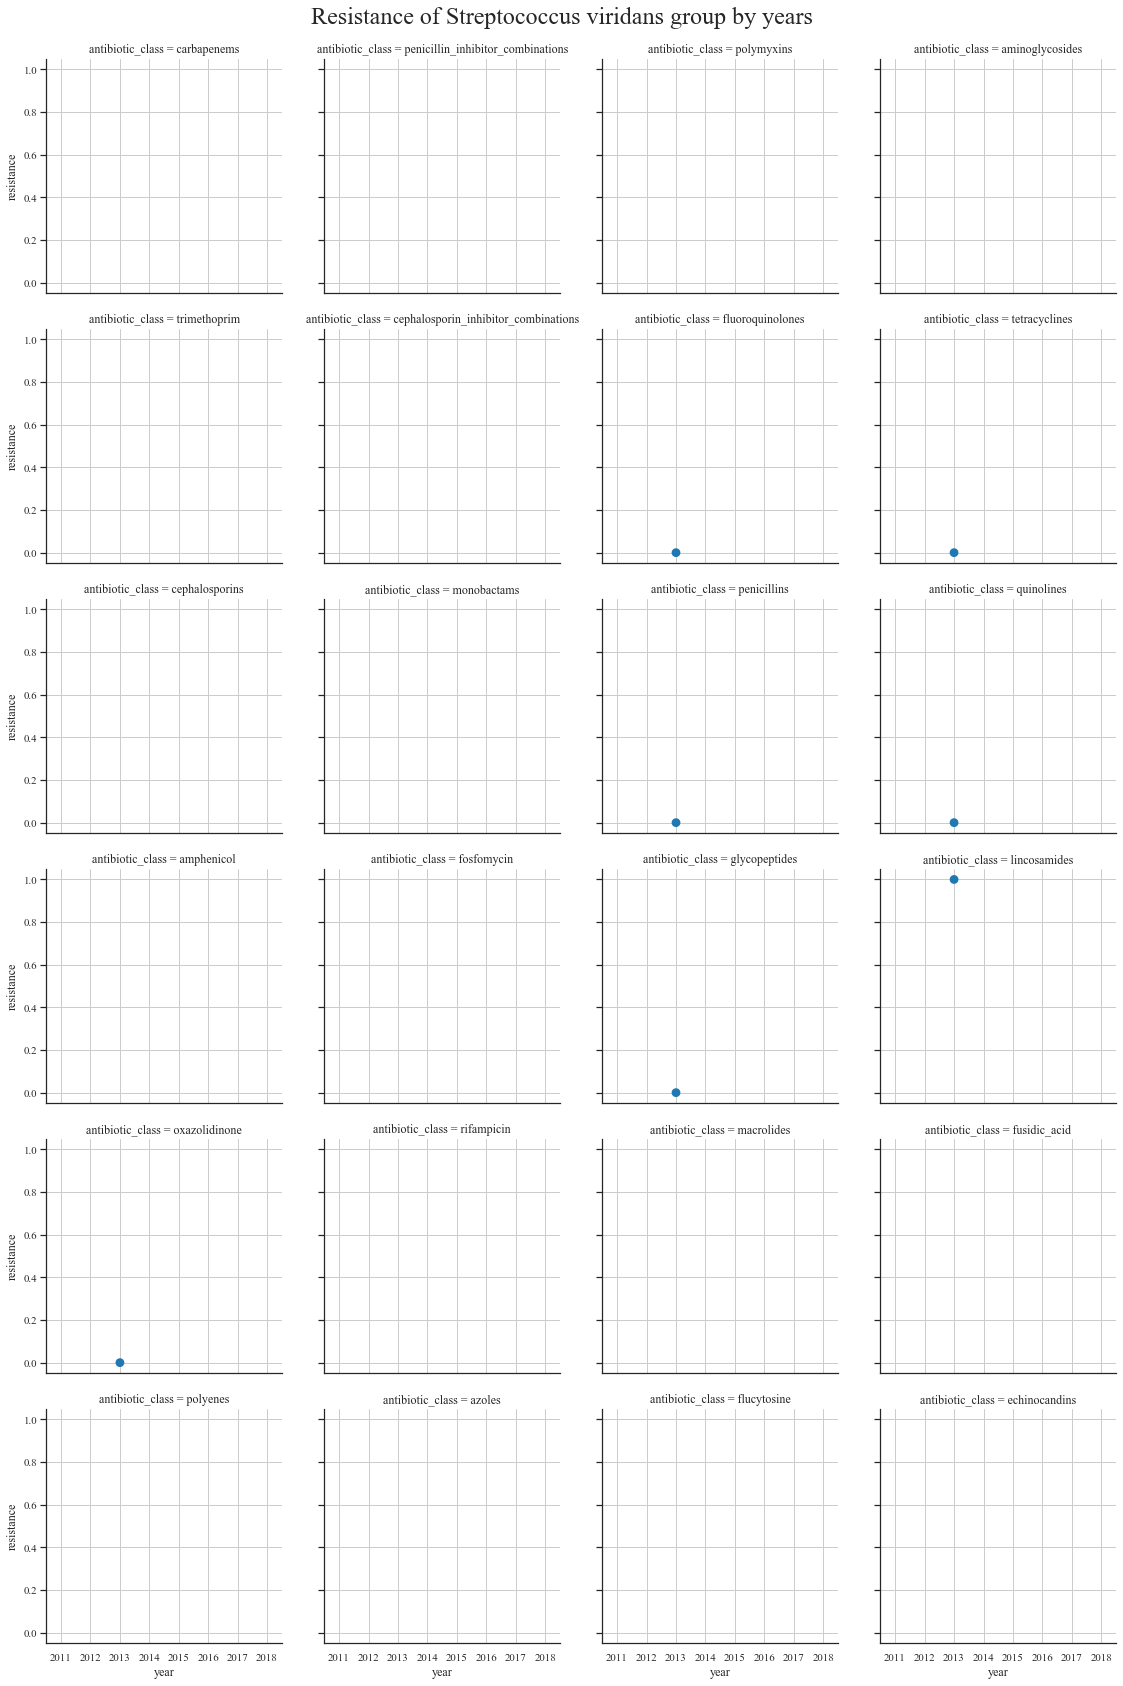

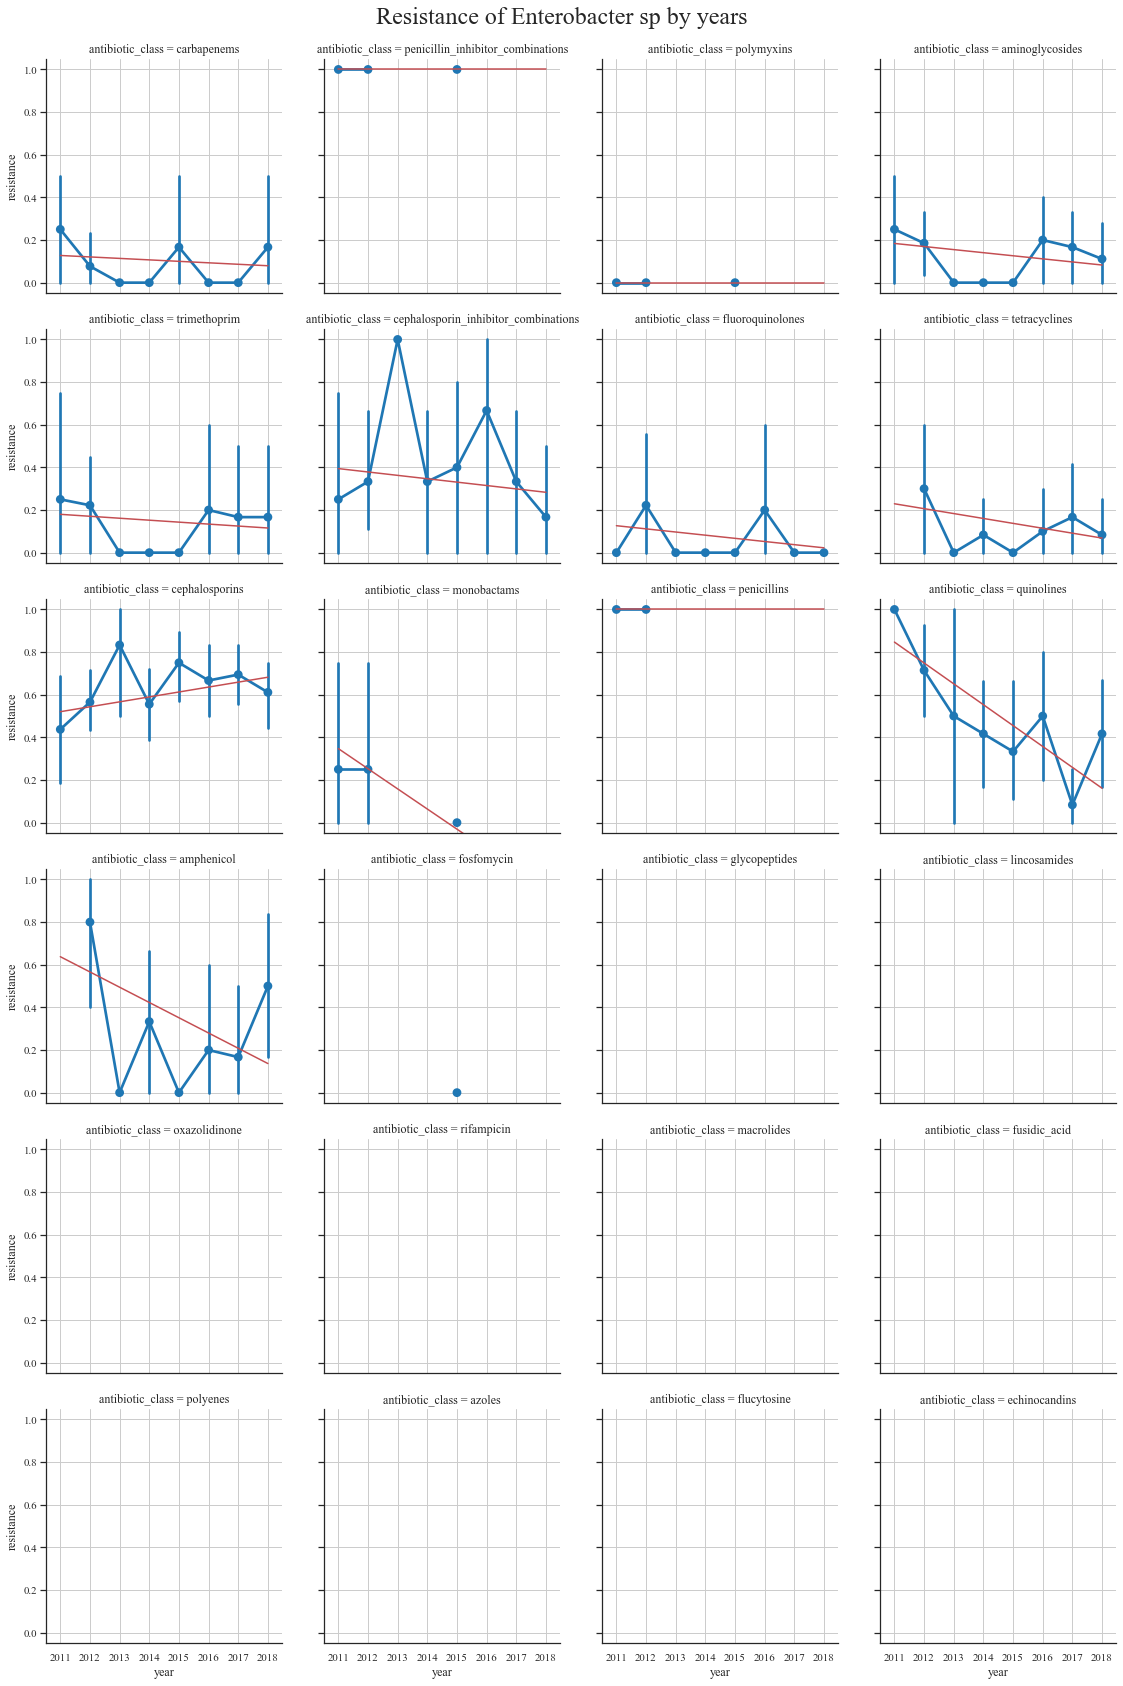

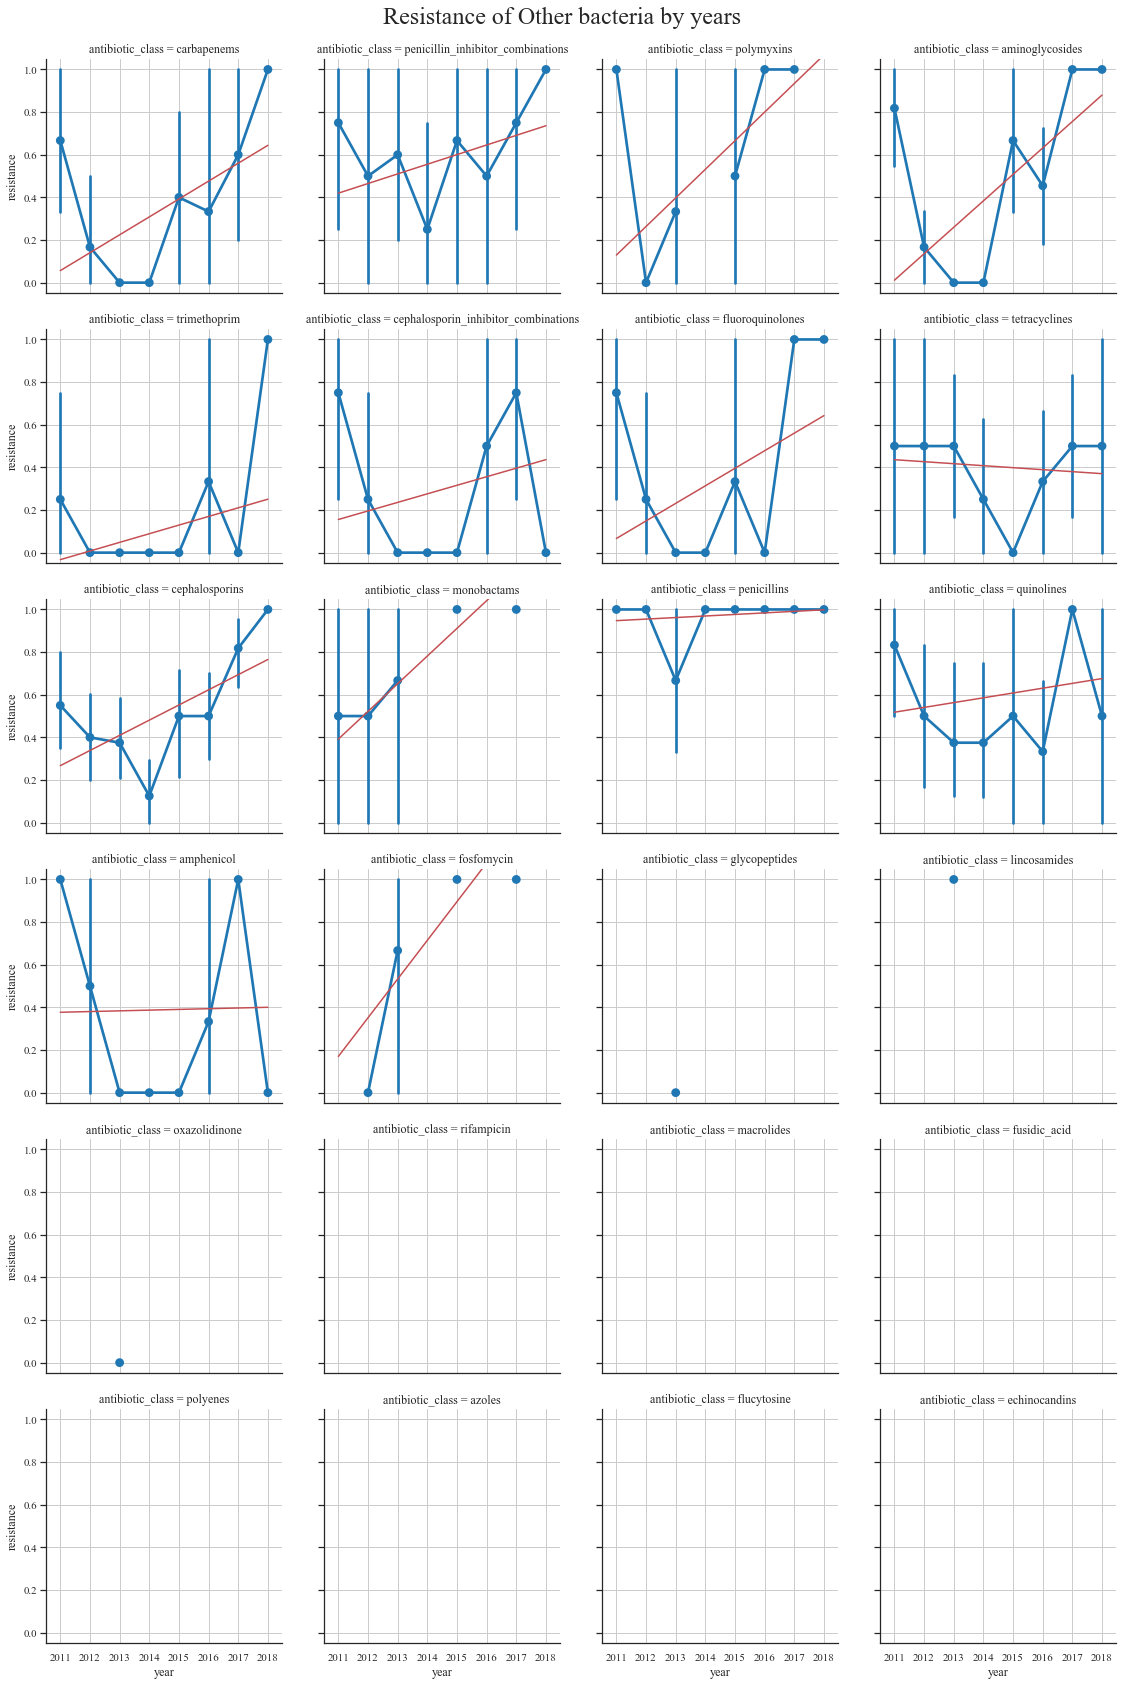

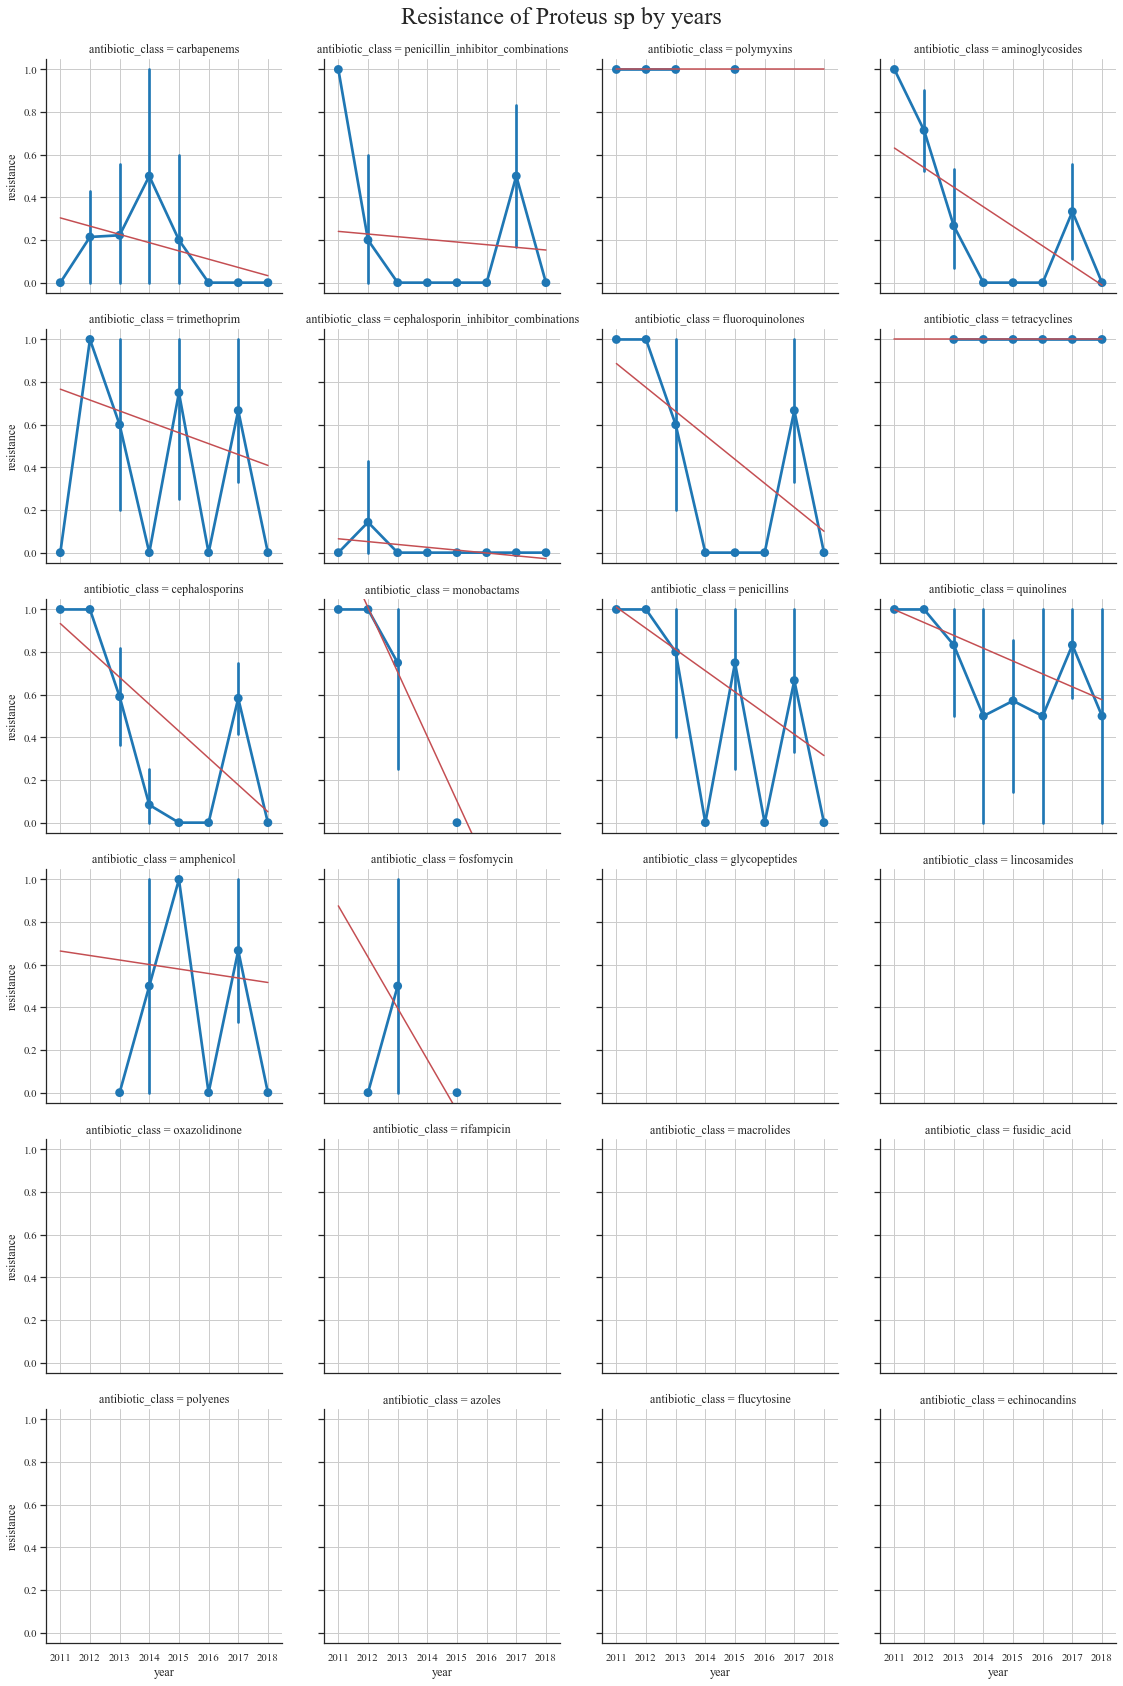

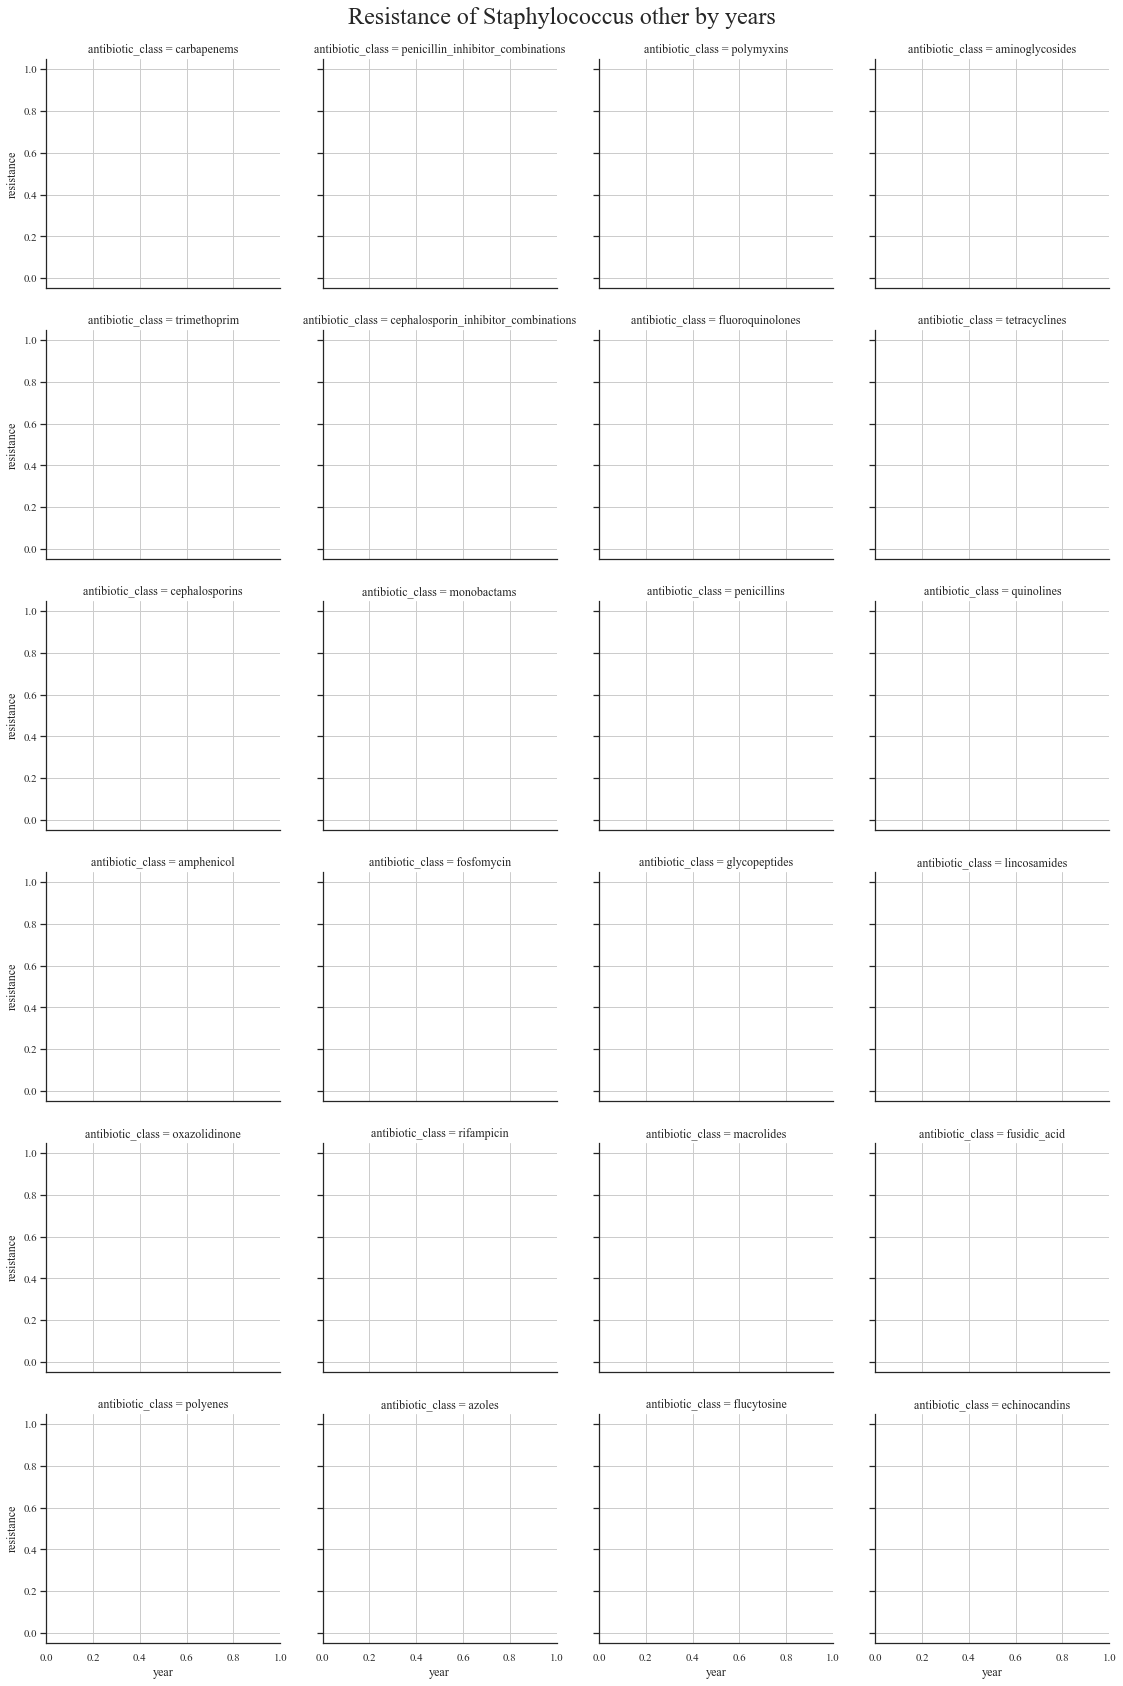

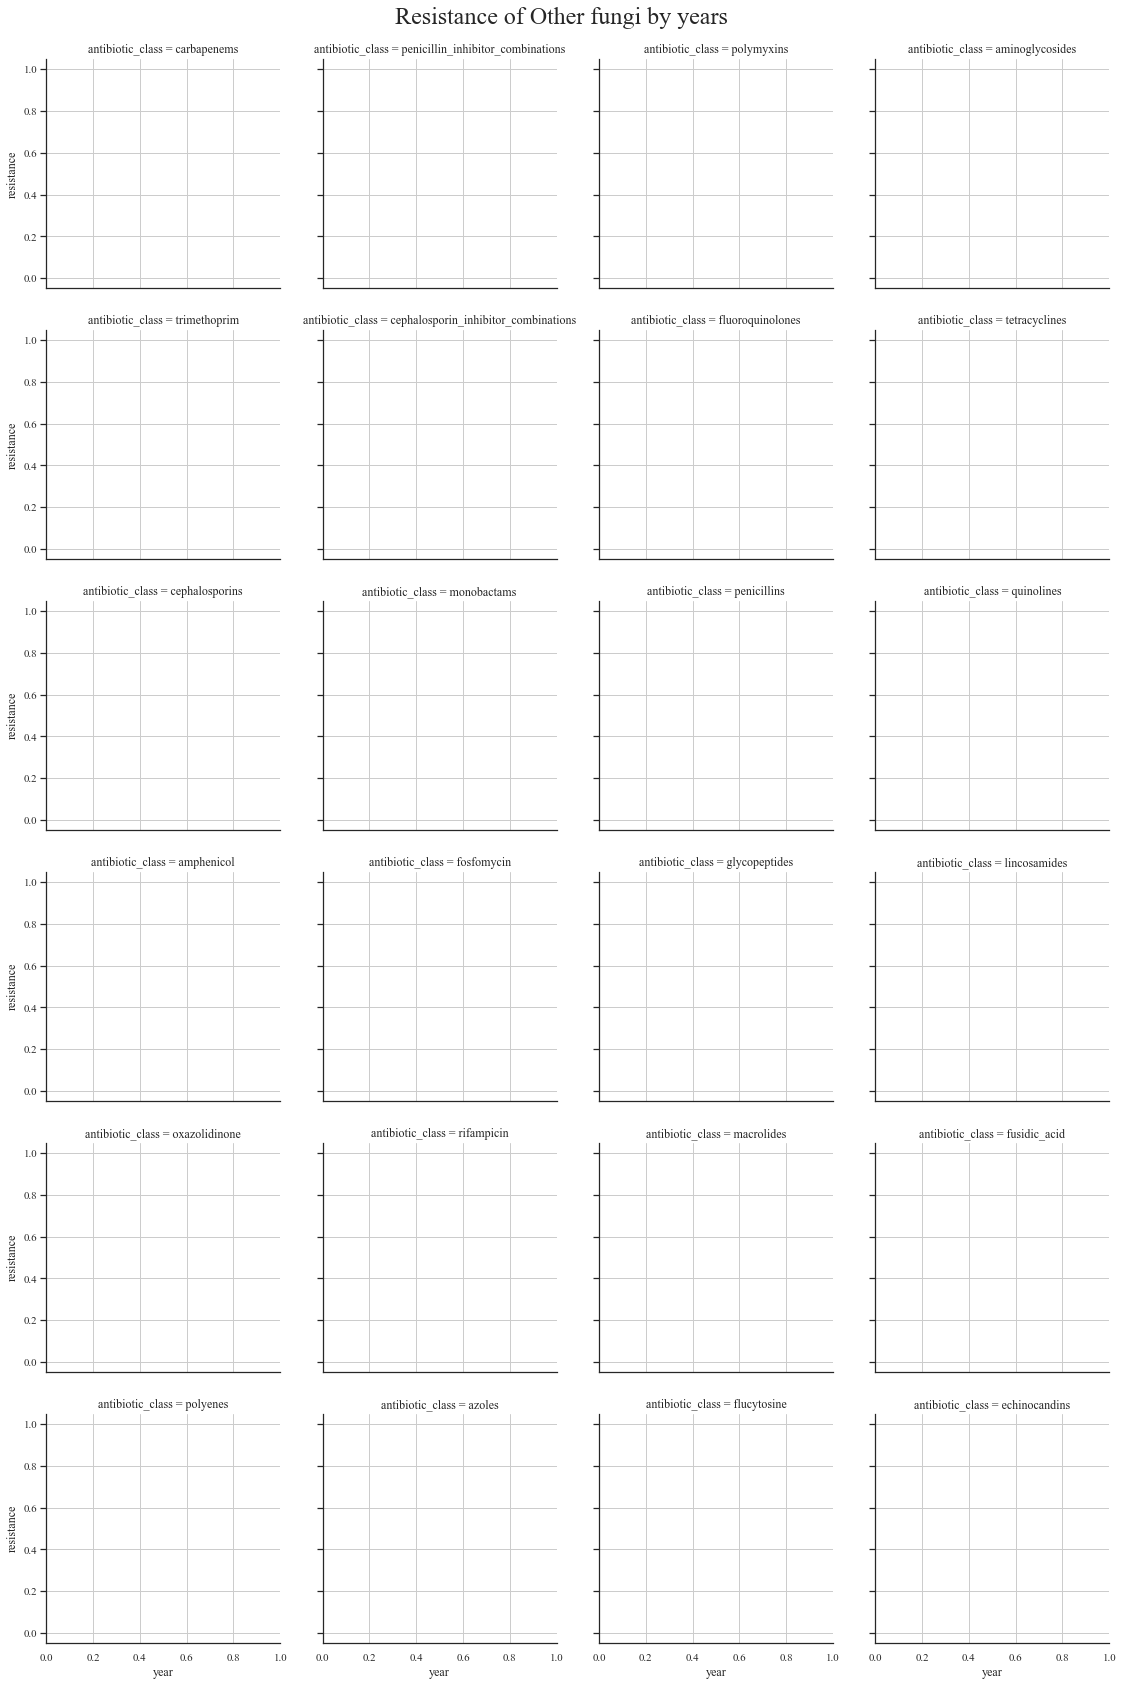

In [30]:
# Plot resistance of each pathogen to each class of antibiotic
col_order = ['carbapenems', 'penicillin_inhibitor_combinations', 'polymyxins', 'aminoglycosides',
             'trimethoprim','cephalosporin_inhibitor_combinations', 'fluoroquinolones','tetracyclines',
             'cephalosporins', 'monobactams', 'penicillins', 'quinolines', 
             'amphenicol', 'fosfomycin', 'glycopeptides', 'lincosamides',
             'oxazolidinone', 'rifampicin', 'macrolides','fusidic_acid',
             'polyenes', 'azoles', 'flucytosine', 'echinocandins'
            ]

FLAG = False
df_inf['month_idx'] = df_inf.date.apply(lambda x: (x.year - 2011) * 12 + (x.month - 1))
for bug in df_inf.bacteria_name.unique():
    t = df_inf[df_inf.bacteria_name == bug]
    g = sns.catplot(x="year", y="resistance", col="antibiotic_class", data=t, kind="point",
                    col_wrap=4, height=4, col_order=col_order)
    for a, col in zip(g.axes, col_order):
        a.grid('dotted')
        a.set_ylim(-0.05,1.05)
        # linreg
        points = df_inf.loc[((df_inf.bacteria_name == bug) & (df_inf.antibiotic_class == col)), ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
        x = points.index
        y = points.values.reshape(-1)
        
        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        
        if len(x) > 2:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)            
            a.plot([0, 7], [intercept, intercept + slope * 96], 'r')            

    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(f"Resistance of {bug}" + " by years")
    g.savefig(f"pictures/resistance_{bug}" + ".pdf", bbox_inches="tight", dpi=600)

In [31]:
# Average resistance to selected antibiotics VA- and NVA- together
important_abx = ['carbapenems', 'cephalosporins', 'polymyxins','fluoroquinolones', 'aminoglycosides',
                 'penicillin_inhibitor_combinations', 'glycopeptides', 'tetracyclines']

df_abx = df_inf[(df_inf.antibiotic_class.isin(important_abx))]

abx = pd.DataFrame()
for ab in df_abx.antibiotic_class.unique():
    d = df_abx[(df_abx.antibiotic_class == ab)]
    s = d.resistance.sum() / d.resistance.count()*100
    cil, cir = ci(d.resistance.sum(), d.resistance.count())
    ab_array =[]
    ab_array = np.append(ab_array, [ab, s, cil*100, cir*100])
    abx = pd.concat([abx, pd.DataFrame(ab_array)], axis=1)
abx = abx.T
abx.columns=(['ab', 'percentage', 'lower', 'upper'])
abx

,ab,percentage,lower,upper
0,glycopeptides,0.7692307692307693,0.0,2.2710854682470916
0,aminoglycosides,43.217347453353504,41.03701044749616,45.39768445921085
0,fluoroquinolones,46.49204864359214,43.50214121667007,49.48195607051422
0,tetracyclines,29.454926624737947,26.562341016872963,32.34751223260293
0,cephalosporins,69.47040498442367,67.8772573912783,71.06355257756903
0,penicillin_inhibitor_combinations,69.90595611285266,66.34689769385919,73.46501453184612
0,carbapenems,41.202672605790646,37.98344703055261,44.42189818102869
0,polymyxins,12.7208480565371,8.83873512690354,16.60296098617066


In [32]:
# Average resistance to selected antibiotics VA-HARTI
important_abx = ['carbapenems', 'cephalosporins', 'polymyxins','fluoroquinolones', 'aminoglycosides',
                 'penicillin_inhibitor_combinations', 'glycopeptides', 'tetracyclines']

df_abx = df_inf[(df_inf.antibiotic_class.isin(important_abx)) & (df_inf.group == 'VA-HARTI')]

abx = pd.DataFrame()
for ab in df_abx.antibiotic_class.unique():
    d = df_abx[(df_abx.antibiotic_class == ab)]
    s = d.resistance.sum() / d.resistance.count()*100
    cil, cir = ci(d.resistance.sum(), d.resistance.count())
    ab_array =[]
    ab_array = np.append(ab_array, [ab, s, cil*100, cir*100])
    abx = pd.concat([abx, pd.DataFrame(ab_array)], axis=1)
abx = abx.T
abx.columns=(['ab', 'percentage', 'lower', 'upper'])
abx

,ab,percentage,lower,upper
0,glycopeptides,1.1235955056179776,0.0,3.3133953326472816
0,aminoglycosides,44.17696811971373,41.69431627269608,46.659619966731384
0,fluoroquinolones,47.701863354037265,44.25153100025091,51.15219570782362
0,tetracyclines,31.339031339031337,27.907584442375803,34.770478235686866
0,cephalosporins,70.09345794392523,68.2845597408636,71.90235614698686
0,penicillin_inhibitor_combinations,70.57654075546719,66.59417497343115,74.55890653750325
0,carbapenems,43.239436619718305,39.59540380847273,46.883469430963885
0,polymyxins,14.224137931034484,9.72944919226709,18.718826669801878


In [33]:
# Average resistance to selected antibiotics NVA-HARTI
important_abx = ['carbapenems', 'cephalosporins', 'polymyxins','fluoroquinolones', 'aminoglycosides',
                 'penicillin_inhibitor_combinations', 'glycopeptides', 'tetracyclines']

df_abx = df_inf[(df_inf.antibiotic_class.isin(important_abx)) & (df_inf.group == 'NVA-HARTI')]

abx = pd.DataFrame()
for ab in df_abx.antibiotic_class.unique():
    d = df_abx[(df_abx.antibiotic_class == ab)]
    s = d.resistance.sum() / d.resistance.count()*100
    cil, cir = ci(d.resistance.sum(), d.resistance.count())
    ab_array =[]
    ab_array = np.append(ab_array, [ab, s, cil*100, cir*100])
    abx = pd.concat([abx, pd.DataFrame(ab_array)], axis=1)
abx = abx.T
abx.columns=(['ab', 'percentage', 'lower', 'upper'])
abx

,ab,percentage,lower,upper
0,aminoglycosides,39.91031390134529,35.365425736198446,44.455202066492134
0,penicillin_inhibitor_combinations,67.4074074074074,59.500721757400164,75.31409305741464
0,carbapenems,33.51063829787234,26.763236098674138,40.258040497070546
0,polymyxins,5.88235294117647,0.0,12.339996548149696
0,cephalosporins,67.42323097463284,64.06689083609147,70.77957111317421
0,fluoroquinolones,42.803030303030305,36.83446573951726,48.771594866543346
0,glycopeptides,0.0,0.0,0.0
0,tetracyclines,24.206349206349206,18.917893381619255,29.494805031079157


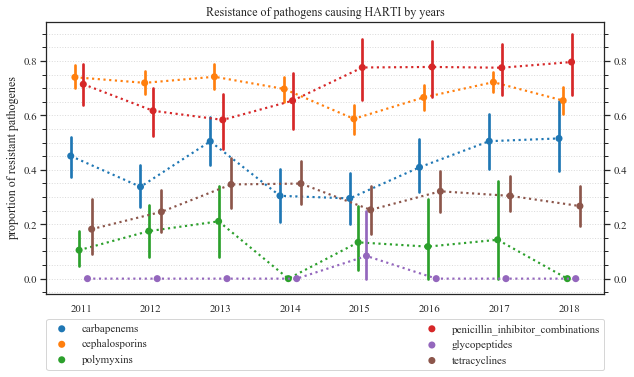

In [34]:
# Plot resistance by years
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

important_abx = ['carbapenems', 'cephalosporins', 'polymyxins',
                 'penicillin_inhibitor_combinations', 'glycopeptides', 'tetracyclines']

fig, ax = plt.subplots(1, figsize=(10,5))
sns.pointplot(x="year", y="resistance", hue="antibiotic_class", data=df_inf, dodge=0.3,
              hue_order=important_abx,
              linestyles='dotted', scale=0.8, join = True, ax=ax)
ax.legend(bbox_to_anchor=(0, -0.28, 1, 0.5), loc=8, ncol=2,
           mode="expand", borderaxespad=0.)
ax.minorticks_on()
ax.grid(which='major', axis='y', linestyle='dotted', alpha=0.7)
ax.grid(which='minor', axis='y', linestyle='dotted', alpha=0.7)
ax.tick_params(axis='y', which='both', right=True)
ax.set_ylabel('proportion of resistant pathogenes')
ax.set_xlabel('')
ax.set_title('Resistance of pathogens causing HARTI by years')
plt.savefig('pictures/resistance_years_all_bacteria.pdf', bbox_inches="tight", dpi=600)

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False

In [35]:
# Test visible dynamics
sd = df_inf[(df_inf.antibiotic_class=='cephalosporins')]
a = rp.crosstab(sd.year, sd.resistance)['resistance'][True] / rp.crosstab(sd.year, sd.resistance)['resistance']['All']
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
x = sm.add_constant(x)
y = a.head(8).values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2.110
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.197
Time:                        10:36:52   Log-Likelihood:                 13.908
No. Observations:                   8   AIC:                            -23.82
Df Residuals:                       6   BIC:                            -23.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.8685     15.266      1.498      0.1

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


## Clinically significant resistance

In [36]:
# Klebsiella to carbapenems
points = df_inf.loc[((df_inf.bacteria_name == 'Klebsiella pneumoniae') & (df_inf.antibiotic_class == 'carbapenems')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.7444691691004164 -0.00046250721447039156


In [37]:
# Klebsiella to cefotaxime
points = df_inf.loc[((df_inf.bacteria_name == 'Klebsiella pneumoniae') & (df_inf.antibiotic == 'cefotaxime')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)


0.763380827814453 -0.0005790347342908579


In [38]:
# Klebsiella to ceftriaxone
points = df_inf.loc[((df_inf.bacteria_name == 'Klebsiella pneumoniae') & (df_inf.antibiotic == 'ceftriaxone')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.19141054620641368 -0.0025723986410707074


In [39]:
# Klebsiella to 3rd gen. cephalosporins
points = df_inf.loc[((df_inf.bacteria_name == 'Klebsiella pneumoniae') & (df_inf.antibiotic_class == 'cephalosporins')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.0017539584061474585 -0.004102157886699372


In [40]:
# Acinetobacter to carbapenems
points = df_inf.loc[((df_inf.bacteria_name == 'Acinetobacter baumannii') & (df_inf.antibiotic_class == 'carbapenems')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.04441809838193364 0.002862948098331545


In [41]:
# Acinetobacter to polymyxins
points = df_inf.loc[((df_inf.bacteria_name == 'Acinetobacter baumannii') & (df_inf.antibiotic_class == 'polymyxins')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.6053180214456277 -0.00010090018993271482


In [42]:
# Acinetobacter to tigecycline
points = df_inf.loc[((df_inf.bacteria_name == 'Acinetobacter baumannii') & (df_inf.antibiotic == 'tigecycline')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)


0.8240522733151971 0.00039314926115052663


In [43]:
# Acinetobacter to aminoglycosides
points = df_inf.loc[((df_inf.bacteria_name == 'Acinetobacter baumannii') & (df_inf.antibiotic_class == 'aminoglycosides')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)


0.741741118869951 0.0004068727477431858


In [44]:
# Pseudomonas aeruginosa to aminoglycosides
points = df_inf.loc[((df_inf.bacteria_name == 'Pseudomonas aeruginosa') & (df_inf.antibiotic_class == 'aminoglycosides')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.43057018696248395 0.0012672817498754767


In [45]:
# Pseudomonas aeruginosa to carbapenems
points = df_inf.loc[((df_inf.bacteria_name == 'Pseudomonas aeruginosa') & (df_inf.antibiotic_class == 'carbapenems')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.8662553784478808 -0.0003041807003293305


In [46]:
# Pseudomonas aeruginosa to polymyxins
points = df_inf.loc[((df_inf.bacteria_name == 'Pseudomonas aeruginosa') & (df_inf.antibiotic_class == 'polymyxins')),
                    ['month_idx', 'resistance']].groupby('month_idx').agg(lambda x: x.mean())        
x = points.index
y = points.values.reshape(-1)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)            
print(p_value, slope)

0.6561551932363615 0.0003200524754191408


# Mortality and resistance

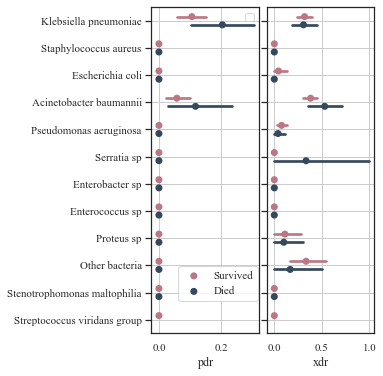

In [47]:
# Plot effect of resistance on mortality

colors_sns = ['#9CDED6', '#BB7784']
colors_sns = ['#BB7784', "#34495e"]
sns.set_palette(sns.color_palette(colors_sns))
fig, ax = plt.subplots(1,2, figsize=(4,6), sharey = True)
ax = ax.ravel()
for i, col in enumerate(['pdr', 'xdr']):
    sns.pointplot(x=col, y="bacteria_name", hue='outcome_death', data=resistance_df,
                  dodge=0.3, join=False, scale=0.8, ax=ax[i])
    ax[i].legend('')
    ax[i].set_ylabel('')
    ax[i].grid('dotted')
    handles, labels = ax[i].get_legend_handles_labels()
plt.subplots_adjust(wspace=0.07, hspace=0.07)
labels =['Survived', 'Died']
plt.legend(handles, labels,
           bbox_to_anchor=(-0.5, 0.1, 0.1, 0.2),
           loc=8,
           borderaxespad=0.)
plt.savefig('pictures/resistance_survival.pdf', bbox_inches="tight", dpi=600)
sns.set_palette("tab10") # set back a default seaborn theme

In [48]:
# Test effect of resistance on mortality
test = resistance_df[['mdr', 'xdr', 'pdr']]
ts = pd.concat([resistance_df[['ID', 'outcome_death', 'group']], test.idxmax(axis=1)], axis=1)

# Compare 2 groups by chi-squared test 
table, results = rp.crosstab(ts[0], ts.outcome_death, prop= 'col', test= 'chi-square')
print(results)

# Post-hoc analysis to compare spectrum by bacteria
dummies = pd.get_dummies(ts[0])
pvals = pd.Series()
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], ts.outcome_death)
    chi2, p, dof, expected = chi(crosstab)
    pvals[series] = p
    nl = "\n"
    print(crosstab, nl)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")
#     print(series)
#     print(f"p-value = {p}{nl}")


                Chi-square test  results
0  Pearson Chi-square ( 2.0) =    6.3950
1                    p-value =    0.0409
2                 Cramer's V =    0.0905
outcome_death    0    1
mdr                    
0              143   51
1              469  118 

Chi2 value= 2.9363237289155286
p-value= 0.08660764222325552
Degrees of freedom= 1

outcome_death    0    1
pdr                    
0              588  155
1               24   14 

Chi2 value= 4.543087538499497
p-value= 0.033051924569250046
Degrees of freedom= 1

outcome_death    0    1
xdr                    
0              493  132
1              119   37 

Chi2 value= 0.3555084702798326
p-value= 0.5510113601902398
Degrees of freedom= 1



In [49]:
print('Mortality in PDR: ', 14/24)
print('Mortality in PDR, CI: ', ci(14, 24))
print('Mortality in non-PDR: ', 167/639)
print('Mortality in non-PDR, CI: ', ci(167, 639))

Mortality in PDR:  0.5833333333333334
Mortality in PDR, CI:  (0.38609321868796853, 0.7805734479786982)
Mortality in non-PDR:  0.26134585289514867
Mortality in non-PDR, CI:  (0.22727946880504915, 0.29541223698524816)


In [50]:
# Test association between carbapenem resistance in Acinetobacter baumannii and mortality
carb_mort = df_inf.merge(vae_data_main[['ID', 'outcome_death']].groupby('ID').max().reset_index(), on='ID')
carb_mort = carb_mort[(carb_mort.antibiotic_class == 'carbapenems')&(carb_mort.bacteria_name.isin(['Acinetobacter baumannii']))]
carb_mort = carb_mort.groupby('ID').max()
table, results = rp.crosstab(carb_mort.resistance, carb_mort.outcome_death, prop= 'col', test= 'chi-square')
print(results)

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    4.5176
1                    p-value =    0.0335
2               Cramer's phi =    0.1741


In [51]:
# Test association between carbapenem resistance in Acinetobacter baumannii and mortality
carb_mort = df_inf.merge(vae_data_main[['ID', 'outcome_death']].groupby('ID').max().reset_index(), on='ID')
carb_mort = carb_mort[(carb_mort.antibiotic_class == 'carbapenems')&(carb_mort.bacteria_name.isin(['Klebsiella pneumoniae']))]
carb_mort = carb_mort.groupby('ID').max()
table, results = rp.crosstab(carb_mort.resistance, carb_mort.outcome_death, prop= 'col', test= 'chi-square')
print(results)

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    3.8178
1                    p-value =    0.0507
2               Cramer's phi =    0.1486


In [52]:
# Test association between carbapenem resistance in all Gram-negatives combined and mortality
carb_mort = df_inf.merge(vae_data_main[['ID', 'outcome_death']].groupby('ID').max().reset_index(), on='ID')
carb_mort = carb_mort[(carb_mort.antibiotic_class == 'carbapenems')&(carb_mort.bacteria_name.isin(['Acinetobacter baumannii',
                                                                                                   'Stenotrophomonas maltophilia',
                                                                                                   'Pseudomonas aeruginosa',
                                                                                                   'Klebsiella pneumoniae',
                                                                                                   'Serratia sp',
                                                                                                   'Escherichia coli',
                                                                                                   'Enterobacter sp', 'Proteus sp']))]
carb_mort = carb_mort.groupby('ID').max()
table, results = rp.crosstab(carb_mort.resistance, carb_mort.outcome_death, prop= 'col', test= 'chi-square')
print(results)

                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.6572
1                    p-value =    0.4176
2               Cramer's phi =    0.0411


__________